# Association Analysis of Filipino Cuisine Ingredients


## Data loading and preview

### Read JSON files

In [1]:
import json
import os


def load_recipes(path="data/recipes"):
    """Combines all recipe data into a single list."""
    files = [file for file in os.listdir(path)]

    recipes = []
    for file in files:
        file_path = os.path.join(path, file)
        with open(file_path, encoding="utf-8") as f:
            recipe_data = json.load(f)
            recipes.extend(recipe_data)

    return recipes


recipes = load_recipes()
recipes[0]

{'link': 'https://www.allrecipes.com/recipe/128699/famous-chicken-adobo/',
 'name': 'Famous Chicken Adobo',
 'ingredients': ['2 tablespoons vegetable oil',
  '1 (3 pound) chicken, cut into pieces',
  '1 large onion, quartered and sliced',
  '2 tablespoons minced garlic',
  ' 2/3  cup low sodium soy sauce',
  ' 1/3  cup white vinegar',
  '1 tablespoon garlic powder',
  '2 teaspoons black pepper',
  '1  bay leaf'],
 'instructions': ['Step 1: Heat vegetable oil in a large skillet over medium-high heat. Cook chicken pieces until golden brown, 2 to 3 minutes per side. Transfer chicken to a plate and set aside.',
  'Step 2: Add onion and garlic to the skillet; cook until softened and brown, about 6 minutes.',
  'Step 3: Pour in soy sauce and vinegar and season with garlic powder, black pepper, and bay leaf.',
  'Step 4: Return chicken to pan, increase heat to high, and bring to a boil. Reduce heat to medium-low, cover, and simmer until chicken is tender and cooked through, 35 to 40 minutes.'

### Convert JSON to DataFrame

In [2]:
import pandas as pd


recipe_df = pd.DataFrame(recipes)
recipe_df.head()

,link,name,ingredients,instructions
0,https://www.allrecipes.com/recipe/128699/famou...,Famous Chicken Adobo,"[2 tablespoons vegetable oil, 1 (3 pound) chic...",[Step 1: Heat vegetable oil in a large skillet...
1,https://www.allrecipes.com/recipe/212994/pinak...,Pinakbet,"[3 tablespoons olive oil, 1 onion, chopped, 2...",[Step 1: Heat oil in a large pot over medium h...
2,https://www.allrecipes.com/recipe/204958/pork-...,Pork Sinigang,"[1 tablespoon vegetable oil, 1 small onion, ch...",[Step 1: Heat vegetable oil in a skillet over ...
3,https://www.allrecipes.com/recipe/270708/lumpi...,Lumpia in the Air Fryer,"[1 pound Italian hot sausage links, 1/2 cup f...",[Step 1: Remove casing from sausage and cook i...
4,https://www.allrecipes.com/recipe/212911/filip...,Filipino Beef Steak,"[4 pounds New York strip steak, sliced thin, 1...",[Step 1: Place sliced beef in a large bowl. Wh...


In [3]:
recipe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4244 entries, 0 to 4243
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   link          4244 non-null   object
 1   name          3898 non-null   object
 2   ingredients   3896 non-null   object
 3   instructions  3872 non-null   object
dtypes: object(4)
memory usage: 132.8+ KB


### Perform EDA on raw dataset

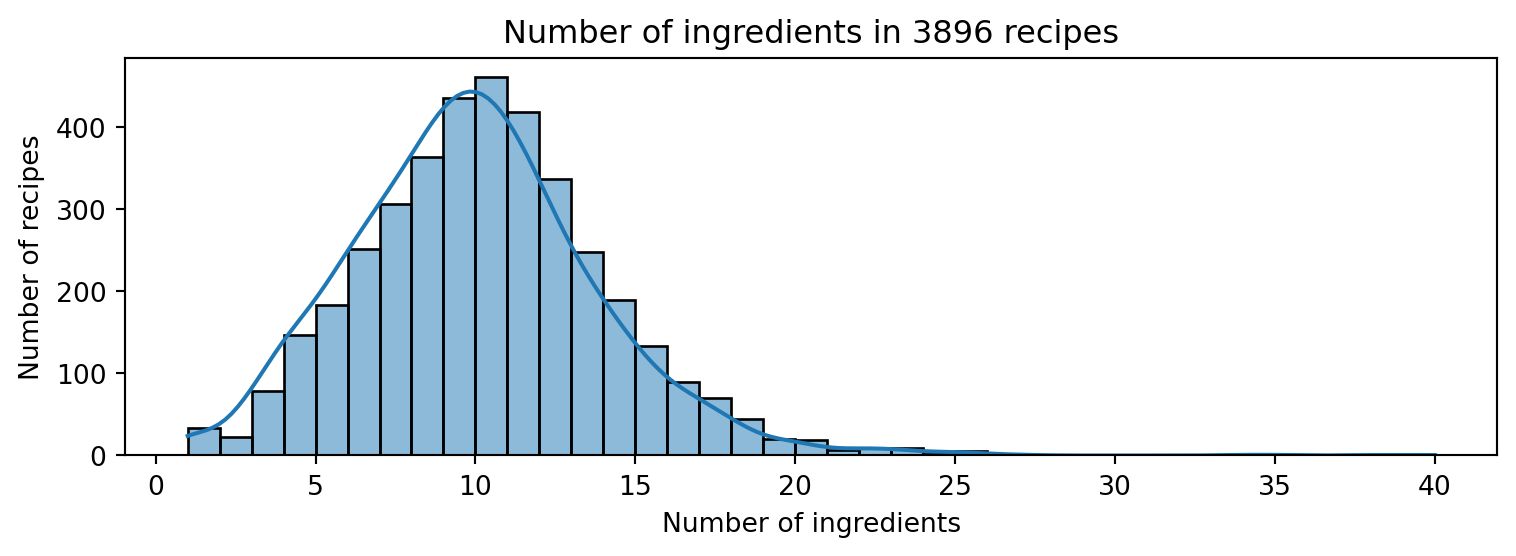

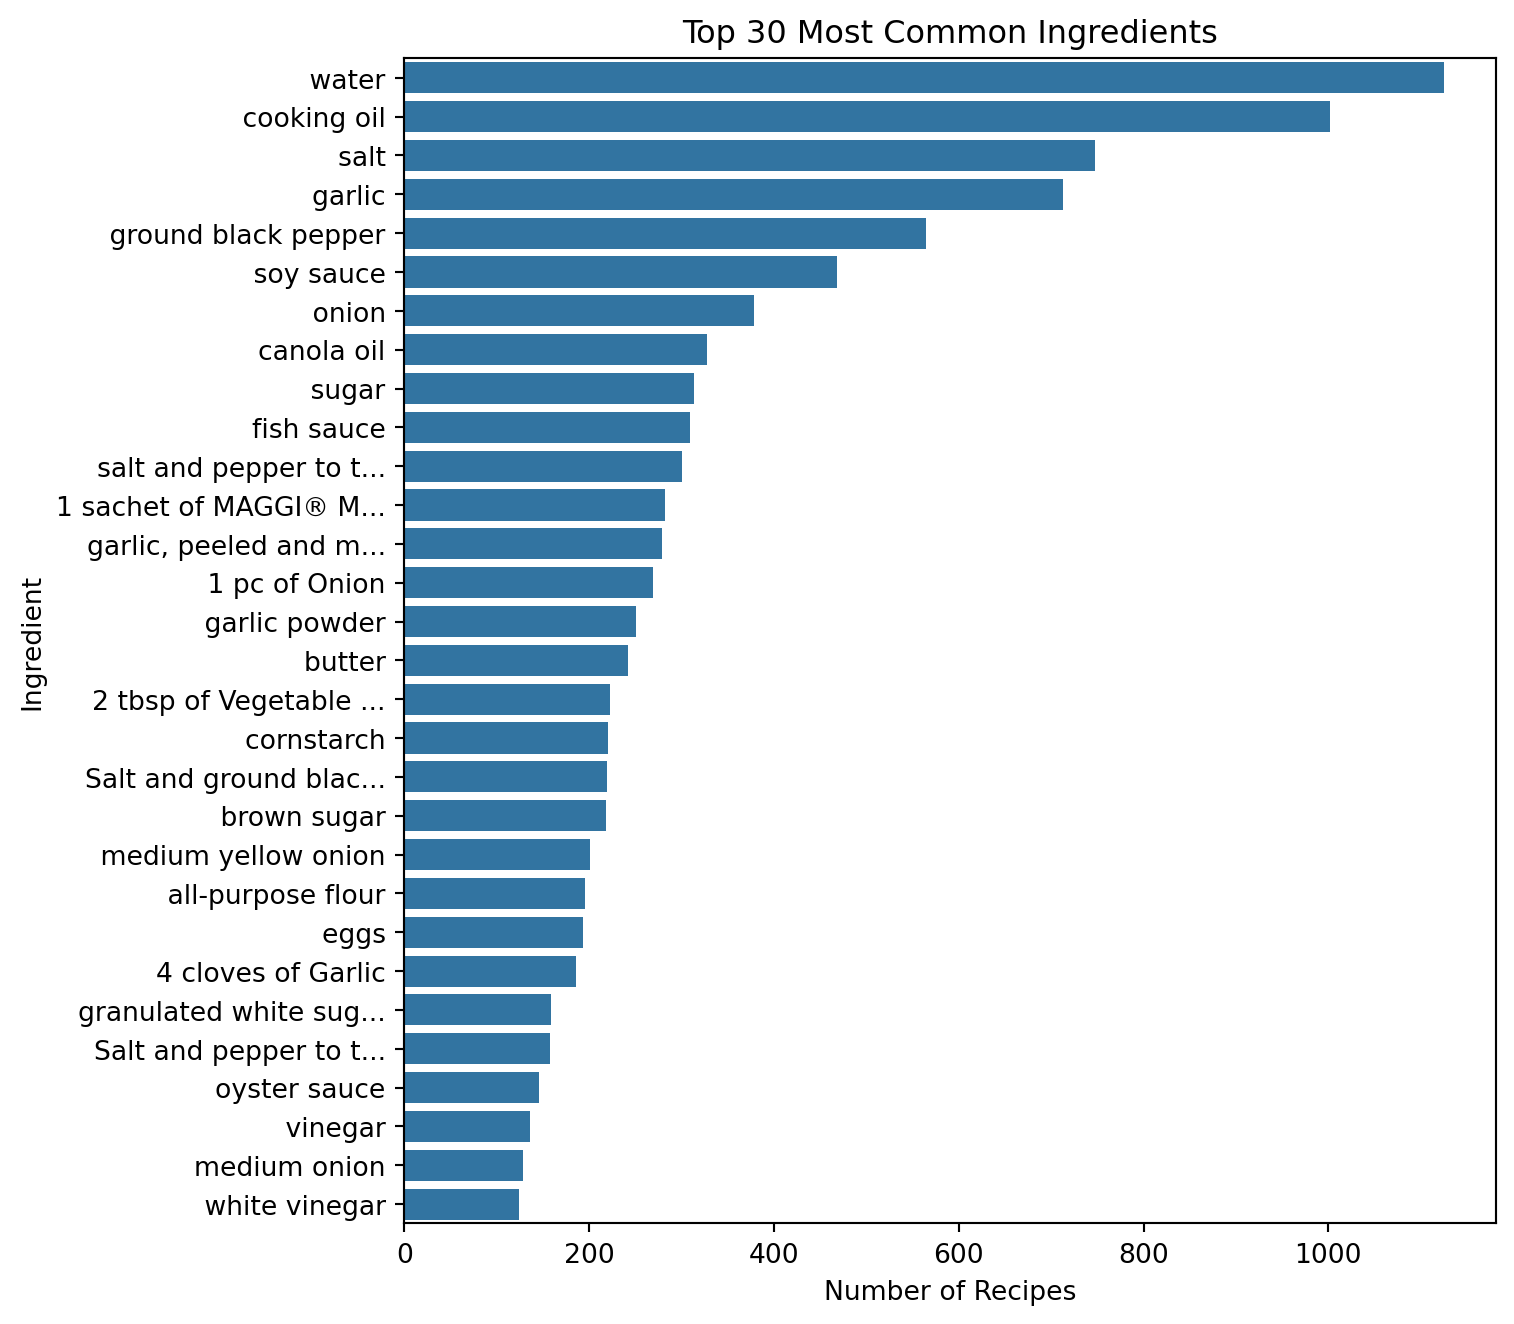

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns


def plot_ingredient_count_distribution(ingredient_series, figsize=(8, 3)):
    """Plots the distribution of the number of ingredients in recipes."""
    counts = ingredient_series.dropna().apply(len)
    plt.figure(figsize=figsize)
    sns.histplot(counts, kde=True, binwidth=1)
    plt.title(f"Number of ingredients in {len(counts)} recipes")
    plt.xlabel("Number of ingredients")
    plt.ylabel("Number of recipes")
    plt.tight_layout()
    plt.show()


def plot_common_ingredients(
    ingredient_series, n=30, most_common=True, figsize=(8, 7)
):
    """Plots the most or least common ingredients."""
    all_ingredients = ingredient_series.dropna().explode()
    ingredient_counts = all_ingredients.value_counts()

    if most_common:
        top_n_ingredients = ingredient_counts.head(n)
    else:
        top_n_ingredients = ingredient_counts.tail(n)

    ylabels = [
        f"{i[:20]:>20}{'...' if len(i) > 20 else ''}"
        for i in top_n_ingredients.index
    ]
    plt.figure(figsize=figsize)
    sns.barplot(x=top_n_ingredients.values, y=ylabels)
    indicator = "Most" if most_common else "Least"
    plt.title(f"Top {n} {indicator} Common Ingredients")
    plt.xlabel("Number of Recipes")
    plt.ylabel("Ingredient")
    plt.tight_layout()
    plt.show()


plot_ingredient_count_distribution(recipe_df.ingredients)
plot_common_ingredients(recipe_df.ingredients, n=30, most_common=True)

## Preprocessing


### Step 0. Remove recipes with no ingredients


In [5]:
def drop_empty_ingredients(recipe_df, column="ingredients"):
    """Drops rows with empty ingredients."""
    new_df = recipe_df.dropna(subset=[column])
    print(f"Dropped {recipe_df.shape[0] - new_df.shape[0]} rows.")
    return new_df


recipe_df = drop_empty_ingredients(recipe_df)

Dropped 348 rows.


In [6]:
def save_ingredients(ingredient_series, path):
    """Saves the ingredients to a TXT file."""
    os.makedirs(os.path.dirname(path), exist_ok=True)

    all_ingredients = ingredient_series.dropna().explode()
    data = sorted(all_ingredients.unique().astype(str))

    with open(path, "w", encoding="utf-8") as file:
        for ingredient in data:
            file.write(f"{ingredient.strip()}\n")


save_ingredients(
    recipe_df.ingredients,
    path="data/preprocess_output/0_raw.txt",
)

### Step 1. Clean ingredient format


In [7]:
import re

from tqdm import tqdm

tqdm.pandas()


def remove_parentheses(ingredient):
    """Removes parentheses and content from ingredient strings."""
    return re.sub(r" ?\([^)]+\)", "", ingredient)


def select_first_option(ingredient):
    """Selects the first option in a string with multiple options."""
    return ingredient.split(" or ")[0]


def clean_ingredient(ingredient):
    """Cleans an ingredient string."""
    ingredient = remove_parentheses(ingredient)
    ingredient = select_first_option(ingredient)
    return ingredient.lower().strip()


recipe_df["cleaned"] = recipe_df.ingredients.progress_apply(
    lambda x: [cleaned for i in x if (cleaned := clean_ingredient(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 117630.60it/s]

In [8]:
save_ingredients(
    recipe_df.cleaned,
    path="data/preprocess_output/1_cleaned.txt",
)

### Step 2. Lemmatize words and remove non-ingredient words


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")


def correct_noun_pos_tags(token):
    """Corrects the POS tags of specific tokens."""
    outliers = ["cauliflower", "baking"]
    if token.text in outliers:
        token.pos_ = "NOUN"
    return token


def lemmatize_nouns(ingredient):
    """Lemmatizes nouns in an ingredient string."""
    doc = nlp(ingredient)
    lemmas = []
    for token in doc:
        token = correct_noun_pos_tags(token)
        if (
            token.is_alpha
            and not token.is_stop
            and token.pos_ in ["NOUN", "PROPN"]
        ):
            lemmas.append(token.lemma_)
    return " ".join(lemmas)


recipe_df["lemmatized"] = recipe_df.cleaned.progress_apply(
    lambda x: [lemmatized for i in x if (lemmatized := lemmatize_nouns(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

  0%|          | 4/3896 [00:00<01:58, 32.97it/s]

  0%|          | 8/3896 [00:00<01:58, 32.93it/s]

  0%|          | 12/3896 [00:00<02:03, 31.43it/s]

  0%|          | 16/3896 [00:00<02:06, 30.63it/s]

  1%|          | 20/3896 [00:00<02:31, 25.64it/s]

  1%|          | 23/3896 [00:00<02:30, 25.70it/s]

  1%|          | 26/3896 [00:00<02:24, 26.72it/s]

  1%|          | 29/3896 [00:01<02:22, 27.15it/s]

  1%|          | 32/3896 [00:01<02:40, 24.00it/s]

  1%|          | 35/3896 [00:01<02:50, 22.70it/s]

  1%|          | 38/3896 [00:01<03:00, 21.38it/s]

  1%|          | 41/3896 [00:01<02:48, 22.92it/s]

  1%|          | 44/3896 [00:01<02:36, 24.64it/s]

  1%|          | 47/3896 [00:01<02:59, 21.48it/s]

  1%|▏         | 50/3896 [00:02<03:11, 20.09it/s]

  1%|▏         | 53/3896 [00:02<03:30, 18.22it/s]

  1%|▏         | 57/3896 [00:02<03:10, 20.15it/s]

  2%|▏         | 60/3896 [00:02<03:41, 17.31it/s]

  2%|▏         | 63/3896 [00:02<03:24, 18.71it/s]

  2%|▏         | 65/3896 [00:02<03:44, 17.08it/s]

  2%|▏         | 68/3896 [00:03<03:51, 16.51it/s]

  2%|▏         | 70/3896 [00:03<05:16, 12.07it/s]

  2%|▏         | 72/3896 [00:03<04:58, 12.80it/s]

  2%|▏         | 75/3896 [00:03<04:11, 15.19it/s]

  2%|▏         | 78/3896 [00:03<03:31, 18.02it/s]

  2%|▏         | 81/3896 [00:03<03:06, 20.49it/s]

  2%|▏         | 84/3896 [00:04<02:55, 21.72it/s]

  2%|▏         | 88/3896 [00:04<02:28, 25.71it/s]

  2%|▏         | 91/3896 [00:04<02:45, 23.03it/s]

  2%|▏         | 94/3896 [00:04<03:04, 20.57it/s]

  3%|▎         | 98/3896 [00:04<02:46, 22.84it/s]

  3%|▎         | 101/3896 [00:04<03:06, 20.34it/s]

  3%|▎         | 104/3896 [00:04<03:08, 20.14it/s]

  3%|▎         | 107/3896 [00:05<03:00, 20.98it/s]

  3%|▎         | 110/3896 [00:05<02:59, 21.03it/s]

  3%|▎         | 113/3896 [00:05<02:55, 21.52it/s]

  3%|▎         | 116/3896 [00:05<02:50, 22.12it/s]

  3%|▎         | 120/3896 [00:05<02:35, 24.29it/s]

  3%|▎         | 123/3896 [00:05<02:30, 25.03it/s]

  3%|▎         | 127/3896 [00:05<02:21, 26.67it/s]

  3%|▎         | 130/3896 [00:06<02:33, 24.54it/s]

  3%|▎         | 133/3896 [00:06<02:42, 23.18it/s]

  3%|▎         | 136/3896 [00:06<02:35, 24.24it/s]

  4%|▎         | 139/3896 [00:06<02:40, 23.42it/s]

  4%|▎         | 142/3896 [00:06<02:36, 23.92it/s]

  4%|▎         | 146/3896 [00:06<02:16, 27.53it/s]

  4%|▍         | 149/3896 [00:06<02:15, 27.60it/s]

  4%|▍         | 152/3896 [00:06<02:35, 24.02it/s]

  4%|▍         | 155/3896 [00:07<02:32, 24.53it/s]

  4%|▍         | 159/3896 [00:07<02:12, 28.22it/s]

  4%|▍         | 162/3896 [00:07<02:14, 27.71it/s]

  4%|▍         | 165/3896 [00:07<02:41, 23.06it/s]

  4%|▍         | 168/3896 [00:07<02:57, 20.96it/s]

  4%|▍         | 171/3896 [00:07<02:52, 21.63it/s]

  4%|▍         | 174/3896 [00:07<02:45, 22.52it/s]

  5%|▍         | 178/3896 [00:07<02:28, 25.03it/s]

  5%|▍         | 181/3896 [00:08<02:40, 23.09it/s]

  5%|▍         | 184/3896 [00:08<02:36, 23.75it/s]

  5%|▍         | 188/3896 [00:08<02:22, 26.05it/s]

  5%|▍         | 192/3896 [00:08<02:24, 25.64it/s]

  5%|▌         | 195/3896 [00:08<02:23, 25.87it/s]

  5%|▌         | 198/3896 [00:08<02:19, 26.56it/s]

  5%|▌         | 203/3896 [00:08<01:57, 31.37it/s]

  5%|▌         | 207/3896 [00:09<01:52, 32.65it/s]

  5%|▌         | 213/3896 [00:09<01:41, 36.43it/s]

  6%|▌         | 217/3896 [00:09<02:21, 26.04it/s]

  6%|▌         | 220/3896 [00:09<02:19, 26.37it/s]

  6%|▌         | 223/3896 [00:09<02:30, 24.33it/s]

  6%|▌         | 226/3896 [00:09<03:12, 19.02it/s]

  6%|▌         | 230/3896 [00:10<02:52, 21.30it/s]

  6%|▌         | 235/3896 [00:10<02:20, 26.06it/s]

  6%|▌         | 239/3896 [00:10<02:10, 28.03it/s]

  6%|▌         | 243/3896 [00:10<02:17, 26.59it/s]

  6%|▋         | 246/3896 [00:10<02:29, 24.37it/s]

  6%|▋         | 249/3896 [00:10<02:29, 24.34it/s]

  6%|▋         | 252/3896 [00:10<02:37, 23.14it/s]

  7%|▋         | 255/3896 [00:11<02:27, 24.64it/s]

  7%|▋         | 258/3896 [00:11<02:30, 24.10it/s]

  7%|▋         | 261/3896 [00:11<02:33, 23.61it/s]

  7%|▋         | 264/3896 [00:11<02:32, 23.79it/s]

  7%|▋         | 268/3896 [00:11<02:11, 27.68it/s]

  7%|▋         | 271/3896 [00:11<02:10, 27.84it/s]

  7%|▋         | 275/3896 [00:11<01:58, 30.58it/s]

  7%|▋         | 279/3896 [00:11<02:20, 25.78it/s]

  7%|▋         | 282/3896 [00:12<02:25, 24.91it/s]

  7%|▋         | 285/3896 [00:12<02:21, 25.48it/s]

  7%|▋         | 288/3896 [00:12<02:24, 25.01it/s]

  7%|▋         | 291/3896 [00:12<02:19, 25.90it/s]

  8%|▊         | 295/3896 [00:12<02:06, 28.46it/s]

  8%|▊         | 299/3896 [00:12<01:59, 30.19it/s]

  8%|▊         | 303/3896 [00:12<02:01, 29.64it/s]

  8%|▊         | 307/3896 [00:12<02:00, 29.67it/s]

  8%|▊         | 310/3896 [00:13<02:07, 28.05it/s]

  8%|▊         | 313/3896 [00:13<02:15, 26.48it/s]

  8%|▊         | 316/3896 [00:13<02:15, 26.40it/s]

  8%|▊         | 319/3896 [00:13<02:11, 27.13it/s]

  8%|▊         | 322/3896 [00:13<02:17, 25.94it/s]

  8%|▊         | 325/3896 [00:13<02:12, 27.00it/s]

  8%|▊         | 328/3896 [00:13<02:22, 25.10it/s]

  8%|▊         | 331/3896 [00:13<02:43, 21.84it/s]

  9%|▊         | 334/3896 [00:14<02:47, 21.23it/s]

  9%|▊         | 338/3896 [00:14<02:25, 24.48it/s]

  9%|▉         | 342/3896 [00:14<02:14, 26.35it/s]

  9%|▉         | 346/3896 [00:14<02:01, 29.30it/s]

  9%|▉         | 350/3896 [00:14<02:04, 28.54it/s]

  9%|▉         | 353/3896 [00:14<02:03, 28.62it/s]

  9%|▉         | 356/3896 [00:14<02:04, 28.39it/s]

  9%|▉         | 359/3896 [00:14<02:18, 25.59it/s]

  9%|▉         | 362/3896 [00:15<02:19, 25.41it/s]

  9%|▉         | 366/3896 [00:15<02:10, 26.95it/s]

  9%|▉         | 369/3896 [00:15<02:16, 25.89it/s]

 10%|▉         | 372/3896 [00:15<02:14, 26.21it/s]

 10%|▉         | 375/3896 [00:15<02:15, 25.90it/s]

 10%|▉         | 378/3896 [00:15<02:40, 21.95it/s]

 10%|▉         | 382/3896 [00:15<02:18, 25.44it/s]

 10%|▉         | 385/3896 [00:15<02:17, 25.56it/s]

 10%|▉         | 389/3896 [00:16<02:17, 25.51it/s]

 10%|█         | 392/3896 [00:16<02:17, 25.54it/s]

 10%|█         | 395/3896 [00:16<02:25, 24.07it/s]

 10%|█         | 398/3896 [00:16<02:38, 22.02it/s]

 10%|█         | 401/3896 [00:16<02:36, 22.28it/s]

 10%|█         | 404/3896 [00:16<02:46, 20.95it/s]

 10%|█         | 407/3896 [00:16<02:52, 20.24it/s]

 11%|█         | 410/3896 [00:17<02:47, 20.83it/s]

 11%|█         | 413/3896 [00:17<02:37, 22.06it/s]

 11%|█         | 418/3896 [00:17<02:06, 27.48it/s]

 11%|█         | 422/3896 [00:17<02:00, 28.80it/s]

 11%|█         | 426/3896 [00:17<01:53, 30.64it/s]

 11%|█         | 430/3896 [00:17<02:10, 26.53it/s]

 11%|█         | 433/3896 [00:17<02:22, 24.23it/s]

 11%|█         | 436/3896 [00:18<02:16, 25.30it/s]

 11%|█▏        | 439/3896 [00:18<02:21, 24.46it/s]

 11%|█▏        | 442/3896 [00:18<02:32, 22.66it/s]

 11%|█▏        | 445/3896 [00:18<02:32, 22.61it/s]

 12%|█▏        | 449/3896 [00:18<02:23, 24.09it/s]

 12%|█▏        | 452/3896 [00:18<02:22, 24.12it/s]

 12%|█▏        | 455/3896 [00:18<02:23, 23.92it/s]

 12%|█▏        | 458/3896 [00:18<02:20, 24.44it/s]

 12%|█▏        | 462/3896 [00:19<02:01, 28.17it/s]

 12%|█▏        | 466/3896 [00:19<01:50, 30.97it/s]

 12%|█▏        | 470/3896 [00:19<02:00, 28.45it/s]

 12%|█▏        | 474/3896 [00:19<01:58, 28.94it/s]

 12%|█▏        | 477/3896 [00:19<02:00, 28.36it/s]

 12%|█▏        | 480/3896 [00:19<02:02, 27.88it/s]

 12%|█▏        | 484/3896 [00:19<01:53, 30.04it/s]

 13%|█▎        | 488/3896 [00:19<01:54, 29.84it/s]

 13%|█▎        | 493/3896 [00:20<01:40, 33.97it/s]

 13%|█▎        | 497/3896 [00:20<01:36, 35.17it/s]

 13%|█▎        | 501/3896 [00:20<01:54, 29.68it/s]

 13%|█▎        | 505/3896 [00:20<02:06, 26.78it/s]

 13%|█▎        | 508/3896 [00:20<02:06, 26.77it/s]

 13%|█▎        | 511/3896 [00:20<02:30, 22.50it/s]

 13%|█▎        | 514/3896 [00:21<02:35, 21.69it/s]

 13%|█▎        | 517/3896 [00:21<02:24, 23.33it/s]

 13%|█▎        | 520/3896 [00:21<02:24, 23.36it/s]

 13%|█▎        | 523/3896 [00:21<02:17, 24.48it/s]

 14%|█▎        | 527/3896 [00:21<02:07, 26.38it/s]

 14%|█▎        | 530/3896 [00:21<02:04, 27.04it/s]

 14%|█▎        | 534/3896 [00:21<02:01, 27.78it/s]

 14%|█▍        | 538/3896 [00:21<01:57, 28.52it/s]

 14%|█▍        | 541/3896 [00:21<02:01, 27.63it/s]

 14%|█▍        | 544/3896 [00:22<02:01, 27.65it/s]

 14%|█▍        | 547/3896 [00:22<02:01, 27.49it/s]

 14%|█▍        | 550/3896 [00:22<02:18, 24.22it/s]

 14%|█▍        | 554/3896 [00:22<02:07, 26.28it/s]

 14%|█▍        | 557/3896 [00:22<02:06, 26.45it/s]

 14%|█▍        | 560/3896 [00:22<02:06, 26.37it/s]

 14%|█▍        | 564/3896 [00:22<01:56, 28.52it/s]

 15%|█▍        | 567/3896 [00:22<01:58, 28.10it/s]

 15%|█▍        | 571/3896 [00:23<01:50, 29.98it/s]

 15%|█▍        | 575/3896 [00:23<01:57, 28.32it/s]

 15%|█▍        | 578/3896 [00:23<01:56, 28.57it/s]

 15%|█▍        | 582/3896 [00:23<01:54, 28.84it/s]

 15%|█▌        | 585/3896 [00:23<02:14, 24.60it/s]

 15%|█▌        | 588/3896 [00:23<02:10, 25.45it/s]

 15%|█▌        | 591/3896 [00:23<02:07, 25.89it/s]

 15%|█▌        | 595/3896 [00:23<02:05, 26.34it/s]

 15%|█▌        | 600/3896 [00:24<01:43, 31.77it/s]

 16%|█▌        | 604/3896 [00:24<01:50, 29.76it/s]

 16%|█▌        | 608/3896 [00:24<02:05, 26.15it/s]

 16%|█▌        | 611/3896 [00:24<02:02, 26.81it/s]

 16%|█▌        | 614/3896 [00:24<02:01, 27.11it/s]

 16%|█▌        | 619/3896 [00:24<01:47, 30.55it/s]

 16%|█▌        | 623/3896 [00:24<01:49, 29.92it/s]

 16%|█▌        | 627/3896 [00:25<01:43, 31.69it/s]

 16%|█▌        | 633/3896 [00:25<01:26, 37.91it/s]

 16%|█▋        | 637/3896 [00:25<01:31, 35.74it/s]

 16%|█▋        | 641/3896 [00:25<01:42, 31.86it/s]

 17%|█▋        | 645/3896 [00:25<01:45, 30.78it/s]

 17%|█▋        | 649/3896 [00:25<01:52, 28.96it/s]

 17%|█▋        | 654/3896 [00:25<01:40, 32.40it/s]

 17%|█▋        | 658/3896 [00:25<01:45, 30.63it/s]

 17%|█▋        | 662/3896 [00:26<01:52, 28.68it/s]

 17%|█▋        | 665/3896 [00:26<01:53, 28.52it/s]

 17%|█▋        | 668/3896 [00:26<01:55, 27.99it/s]

 17%|█▋        | 671/3896 [00:26<01:59, 27.04it/s]

 17%|█▋        | 674/3896 [00:26<01:58, 27.19it/s]

 17%|█▋        | 677/3896 [00:26<02:15, 23.84it/s]

 17%|█▋        | 680/3896 [00:26<02:19, 23.11it/s]

 18%|█▊        | 683/3896 [00:27<02:20, 22.87it/s]

 18%|█▊        | 686/3896 [00:27<02:18, 23.24it/s]

 18%|█▊        | 689/3896 [00:27<02:24, 22.18it/s]

 18%|█▊        | 693/3896 [00:27<02:04, 25.68it/s]

 18%|█▊        | 697/3896 [00:27<01:56, 27.50it/s]

 18%|█▊        | 700/3896 [00:27<01:54, 27.84it/s]

 18%|█▊        | 703/3896 [00:27<02:07, 25.01it/s]

 18%|█▊        | 707/3896 [00:27<01:59, 26.76it/s]

 18%|█▊        | 710/3896 [00:28<02:05, 25.32it/s]

 18%|█▊        | 713/3896 [00:28<02:03, 25.76it/s]

 18%|█▊        | 717/3896 [00:28<01:56, 27.38it/s]

 18%|█▊        | 720/3896 [00:28<02:05, 25.24it/s]

 19%|█▊        | 723/3896 [00:28<02:20, 22.64it/s]

 19%|█▊        | 726/3896 [00:28<02:20, 22.56it/s]

 19%|█▊        | 729/3896 [00:28<02:16, 23.17it/s]

 19%|█▉        | 733/3896 [00:29<02:01, 25.97it/s]

 19%|█▉        | 736/3896 [00:29<02:02, 25.81it/s]

 19%|█▉        | 739/3896 [00:29<02:01, 26.08it/s]

 19%|█▉        | 742/3896 [00:29<01:56, 27.00it/s]

 19%|█▉        | 745/3896 [00:29<02:00, 26.12it/s]

 19%|█▉        | 748/3896 [00:29<01:58, 26.59it/s]

 19%|█▉        | 752/3896 [00:29<01:50, 28.37it/s]

 19%|█▉        | 755/3896 [00:29<02:08, 24.39it/s]

 19%|█▉        | 758/3896 [00:29<02:10, 24.11it/s]

 20%|█▉        | 762/3896 [00:30<01:53, 27.70it/s]

 20%|█▉        | 765/3896 [00:30<02:10, 24.06it/s]

 20%|█▉        | 768/3896 [00:30<02:20, 22.25it/s]

 20%|█▉        | 771/3896 [00:30<02:21, 22.10it/s]

 20%|█▉        | 774/3896 [00:30<02:12, 23.56it/s]

 20%|█▉        | 777/3896 [00:30<02:10, 23.91it/s]

 20%|██        | 780/3896 [00:30<02:16, 22.89it/s]

 20%|██        | 783/3896 [00:31<02:20, 22.23it/s]

 20%|██        | 786/3896 [00:31<02:18, 22.40it/s]

 20%|██        | 789/3896 [00:31<02:22, 21.83it/s]

 20%|██        | 792/3896 [00:31<02:14, 23.06it/s]

 20%|██        | 795/3896 [00:31<02:18, 22.35it/s]

 20%|██        | 798/3896 [00:31<02:25, 21.30it/s]

 21%|██        | 802/3896 [00:31<02:09, 23.88it/s]

 21%|██        | 805/3896 [00:32<02:05, 24.68it/s]

 21%|██        | 808/3896 [00:32<02:03, 24.95it/s]

 21%|██        | 811/3896 [00:32<02:00, 25.71it/s]

 21%|██        | 814/3896 [00:32<02:07, 24.26it/s]

 21%|██        | 817/3896 [00:32<02:05, 24.47it/s]

 21%|██        | 820/3896 [00:32<02:12, 23.16it/s]

 21%|██        | 823/3896 [00:32<02:04, 24.60it/s]

 21%|██        | 826/3896 [00:32<02:11, 23.42it/s]

 21%|██▏       | 829/3896 [00:33<02:29, 20.47it/s]

 21%|██▏       | 832/3896 [00:33<02:17, 22.26it/s]

 21%|██▏       | 835/3896 [00:33<02:23, 21.26it/s]

 22%|██▏       | 838/3896 [00:33<02:23, 21.36it/s]

 22%|██▏       | 841/3896 [00:33<02:20, 21.80it/s]

 22%|██▏       | 844/3896 [00:33<02:26, 20.79it/s]

 22%|██▏       | 847/3896 [00:33<02:19, 21.84it/s]

 22%|██▏       | 852/3896 [00:34<01:55, 26.35it/s]

 22%|██▏       | 855/3896 [00:34<01:54, 26.62it/s]

 22%|██▏       | 858/3896 [00:34<02:01, 24.97it/s]

 22%|██▏       | 861/3896 [00:34<02:08, 23.64it/s]

 22%|██▏       | 864/3896 [00:34<02:03, 24.48it/s]

 22%|██▏       | 867/3896 [00:34<02:07, 23.83it/s]

 22%|██▏       | 871/3896 [00:34<01:58, 25.50it/s]

 22%|██▏       | 875/3896 [00:34<01:51, 27.02it/s]

 23%|██▎       | 878/3896 [00:35<01:58, 25.50it/s]

 23%|██▎       | 881/3896 [00:35<01:58, 25.54it/s]

 23%|██▎       | 884/3896 [00:35<02:04, 24.16it/s]

 23%|██▎       | 887/3896 [00:35<02:06, 23.71it/s]

 23%|██▎       | 891/3896 [00:35<01:54, 26.16it/s]

 23%|██▎       | 894/3896 [00:35<01:57, 25.59it/s]

 23%|██▎       | 897/3896 [00:35<01:54, 26.10it/s]

 23%|██▎       | 900/3896 [00:35<02:07, 23.57it/s]

 23%|██▎       | 904/3896 [00:36<01:54, 26.20it/s]

 23%|██▎       | 907/3896 [00:36<01:55, 25.94it/s]

 23%|██▎       | 910/3896 [00:36<01:52, 26.43it/s]

 23%|██▎       | 913/3896 [00:36<02:01, 24.54it/s]

 24%|██▎       | 916/3896 [00:36<01:59, 24.97it/s]

 24%|██▎       | 919/3896 [00:36<02:06, 23.50it/s]

 24%|██▎       | 923/3896 [00:36<02:05, 23.61it/s]

 24%|██▍       | 926/3896 [00:37<02:14, 22.08it/s]

 24%|██▍       | 929/3896 [00:37<02:11, 22.56it/s]

 24%|██▍       | 932/3896 [00:37<02:07, 23.19it/s]

 24%|██▍       | 935/3896 [00:37<02:07, 23.30it/s]

 24%|██▍       | 938/3896 [00:37<02:05, 23.58it/s]

 24%|██▍       | 941/3896 [00:37<01:58, 24.99it/s]

 24%|██▍       | 944/3896 [00:37<02:02, 24.09it/s]

 24%|██▍       | 947/3896 [00:37<02:09, 22.76it/s]

 24%|██▍       | 950/3896 [00:38<02:03, 23.95it/s]

 24%|██▍       | 953/3896 [00:38<02:07, 23.13it/s]

 25%|██▍       | 956/3896 [00:38<02:08, 22.86it/s]

 25%|██▍       | 959/3896 [00:38<02:17, 21.29it/s]

 25%|██▍       | 962/3896 [00:38<02:20, 20.95it/s]

 25%|██▍       | 965/3896 [00:38<02:13, 21.96it/s]

 25%|██▍       | 968/3896 [00:38<02:29, 19.56it/s]

 25%|██▍       | 971/3896 [00:39<02:36, 18.64it/s]

 25%|██▌       | 974/3896 [00:39<02:30, 19.42it/s]

 25%|██▌       | 977/3896 [00:39<02:19, 20.87it/s]

 25%|██▌       | 980/3896 [00:39<02:11, 22.24it/s]

 25%|██▌       | 983/3896 [00:39<02:03, 23.53it/s]

 25%|██▌       | 986/3896 [00:39<02:06, 22.93it/s]

 25%|██▌       | 989/3896 [00:39<01:59, 24.24it/s]

 25%|██▌       | 992/3896 [00:40<02:18, 20.91it/s]

 26%|██▌       | 995/3896 [00:40<02:15, 21.38it/s]

 26%|██▌       | 998/3896 [00:40<02:04, 23.35it/s]

 26%|██▌       | 1001/3896 [00:40<02:02, 23.57it/s]

 26%|██▌       | 1004/3896 [00:40<02:02, 23.57it/s]

 26%|██▌       | 1007/3896 [00:40<02:00, 24.05it/s]

 26%|██▌       | 1010/3896 [00:40<01:53, 25.52it/s]

 26%|██▌       | 1013/3896 [00:40<02:00, 23.94it/s]

 26%|██▌       | 1016/3896 [00:41<01:56, 24.77it/s]

 26%|██▌       | 1019/3896 [00:41<02:02, 23.56it/s]

 26%|██▌       | 1022/3896 [00:41<02:01, 23.57it/s]

 26%|██▋       | 1025/3896 [00:41<01:55, 24.91it/s]

 26%|██▋       | 1028/3896 [00:41<02:12, 21.72it/s]

 26%|██▋       | 1031/3896 [00:41<02:05, 22.75it/s]

 27%|██▋       | 1034/3896 [00:41<01:57, 24.34it/s]

 27%|██▋       | 1037/3896 [00:41<02:05, 22.77it/s]

 27%|██▋       | 1040/3896 [00:42<02:05, 22.69it/s]

 27%|██▋       | 1043/3896 [00:42<02:15, 21.11it/s]

 27%|██▋       | 1046/3896 [00:42<02:07, 22.39it/s]

 27%|██▋       | 1049/3896 [00:42<02:06, 22.51it/s]

 27%|██▋       | 1052/3896 [00:42<02:04, 22.85it/s]

 27%|██▋       | 1055/3896 [00:42<02:00, 23.63it/s]

 27%|██▋       | 1058/3896 [00:42<01:59, 23.82it/s]

 27%|██▋       | 1061/3896 [00:42<01:54, 24.81it/s]

 27%|██▋       | 1064/3896 [00:43<01:51, 25.44it/s]

 27%|██▋       | 1068/3896 [00:43<01:43, 27.41it/s]

 28%|██▊       | 1072/3896 [00:43<01:40, 28.24it/s]

 28%|██▊       | 1075/3896 [00:43<01:42, 27.45it/s]

 28%|██▊       | 1078/3896 [00:43<01:44, 26.90it/s]

 28%|██▊       | 1081/3896 [00:43<01:53, 24.84it/s]

 28%|██▊       | 1085/3896 [00:43<01:51, 25.20it/s]

 28%|██▊       | 1089/3896 [00:43<01:42, 27.29it/s]

 28%|██▊       | 1092/3896 [00:44<01:43, 27.15it/s]

 28%|██▊       | 1095/3896 [00:44<01:43, 27.05it/s]

 28%|██▊       | 1098/3896 [00:44<01:42, 27.34it/s]

 28%|██▊       | 1102/3896 [00:44<01:37, 28.66it/s]

 28%|██▊       | 1105/3896 [00:44<01:43, 26.92it/s]

 28%|██▊       | 1108/3896 [00:44<01:44, 26.60it/s]

 29%|██▊       | 1111/3896 [00:44<02:02, 22.73it/s]

 29%|██▊       | 1114/3896 [00:44<01:58, 23.45it/s]

 29%|██▊       | 1117/3896 [00:45<02:01, 22.82it/s]

 29%|██▊       | 1120/3896 [00:45<01:55, 24.08it/s]

 29%|██▉       | 1123/3896 [00:45<01:50, 25.07it/s]

 29%|██▉       | 1126/3896 [00:45<01:50, 25.03it/s]

 29%|██▉       | 1129/3896 [00:45<01:46, 26.06it/s]

 29%|██▉       | 1132/3896 [00:45<01:42, 26.96it/s]

 29%|██▉       | 1135/3896 [00:45<01:45, 26.25it/s]

 29%|██▉       | 1138/3896 [00:45<01:45, 26.04it/s]

 29%|██▉       | 1141/3896 [00:46<02:00, 22.91it/s]

 29%|██▉       | 1144/3896 [00:46<01:59, 23.06it/s]

 29%|██▉       | 1147/3896 [00:46<02:04, 22.15it/s]

 30%|██▉       | 1150/3896 [00:46<01:57, 23.36it/s]

 30%|██▉       | 1153/3896 [00:46<02:00, 22.75it/s]

 30%|██▉       | 1156/3896 [00:46<02:05, 21.92it/s]

 30%|██▉       | 1159/3896 [00:46<02:02, 22.35it/s]

 30%|██▉       | 1162/3896 [00:47<02:07, 21.43it/s]

 30%|██▉       | 1165/3896 [00:47<01:59, 22.89it/s]

 30%|██▉       | 1168/3896 [00:47<01:54, 23.82it/s]

 30%|███       | 1171/3896 [00:47<01:57, 23.24it/s]

 30%|███       | 1175/3896 [00:47<01:49, 24.79it/s]

 30%|███       | 1178/3896 [00:47<01:45, 25.88it/s]

 30%|███       | 1181/3896 [00:47<01:45, 25.63it/s]

 30%|███       | 1185/3896 [00:47<01:34, 28.56it/s]

 30%|███       | 1188/3896 [00:48<01:45, 25.72it/s]

 31%|███       | 1191/3896 [00:48<01:43, 26.23it/s]

 31%|███       | 1195/3896 [00:48<01:36, 27.97it/s]

 31%|███       | 1199/3896 [00:48<01:36, 27.84it/s]

 31%|███       | 1202/3896 [00:48<01:42, 26.34it/s]

 31%|███       | 1205/3896 [00:48<01:51, 24.15it/s]

 31%|███       | 1208/3896 [00:48<02:00, 22.38it/s]

 31%|███       | 1211/3896 [00:49<02:10, 20.63it/s]

 31%|███       | 1215/3896 [00:49<01:53, 23.71it/s]

 31%|███▏      | 1218/3896 [00:49<01:55, 23.14it/s]

 31%|███▏      | 1221/3896 [00:49<01:51, 24.06it/s]

 31%|███▏      | 1224/3896 [00:49<01:45, 25.42it/s]

 31%|███▏      | 1227/3896 [00:49<01:51, 23.92it/s]

 32%|███▏      | 1231/3896 [00:49<01:44, 25.45it/s]

 32%|███▏      | 1234/3896 [00:49<01:43, 25.78it/s]

 32%|███▏      | 1237/3896 [00:49<01:40, 26.43it/s]

 32%|███▏      | 1240/3896 [00:50<01:49, 24.20it/s]

 32%|███▏      | 1243/3896 [00:50<01:47, 24.58it/s]

 32%|███▏      | 1246/3896 [00:50<01:52, 23.65it/s]

 32%|███▏      | 1249/3896 [00:50<01:52, 23.58it/s]

 32%|███▏      | 1252/3896 [00:50<01:52, 23.54it/s]

 32%|███▏      | 1255/3896 [00:50<01:49, 24.11it/s]

 32%|███▏      | 1258/3896 [00:50<01:47, 24.53it/s]

 32%|███▏      | 1261/3896 [00:51<01:51, 23.58it/s]

 32%|███▏      | 1264/3896 [00:51<01:48, 24.16it/s]

 33%|███▎      | 1267/3896 [00:51<01:52, 23.34it/s]

 33%|███▎      | 1270/3896 [00:51<01:46, 24.55it/s]

 33%|███▎      | 1273/3896 [00:51<01:41, 25.86it/s]

 33%|███▎      | 1276/3896 [00:51<01:42, 25.48it/s]

 33%|███▎      | 1279/3896 [00:51<01:48, 24.20it/s]

 33%|███▎      | 1282/3896 [00:51<01:46, 24.58it/s]

 33%|███▎      | 1285/3896 [00:51<01:42, 25.54it/s]

 33%|███▎      | 1288/3896 [00:52<01:47, 24.23it/s]

 33%|███▎      | 1291/3896 [00:52<01:48, 24.05it/s]

 33%|███▎      | 1294/3896 [00:52<02:17, 18.98it/s]

 33%|███▎      | 1297/3896 [00:52<02:06, 20.58it/s]

 33%|███▎      | 1300/3896 [00:52<02:30, 17.21it/s]

 33%|███▎      | 1302/3896 [00:52<02:34, 16.78it/s]

 33%|███▎      | 1305/3896 [00:53<02:21, 18.29it/s]

 34%|███▎      | 1307/3896 [00:53<02:34, 16.77it/s]

 34%|███▎      | 1310/3896 [00:53<02:25, 17.80it/s]

 34%|███▎      | 1313/3896 [00:53<02:15, 19.03it/s]

 34%|███▍      | 1315/3896 [00:53<02:16, 18.91it/s]

 34%|███▍      | 1319/3896 [00:53<01:49, 23.61it/s]

 34%|███▍      | 1322/3896 [00:53<01:43, 24.88it/s]

 34%|███▍      | 1326/3896 [00:53<01:39, 25.84it/s]

 34%|███▍      | 1329/3896 [00:54<01:37, 26.27it/s]

 34%|███▍      | 1332/3896 [00:54<01:34, 27.17it/s]

 34%|███▍      | 1335/3896 [00:54<01:43, 24.63it/s]

 34%|███▍      | 1338/3896 [00:54<01:39, 25.64it/s]

 34%|███▍      | 1341/3896 [00:54<01:53, 22.52it/s]

 34%|███▍      | 1344/3896 [00:54<02:11, 19.45it/s]

 35%|███▍      | 1347/3896 [00:55<02:27, 17.25it/s]

 35%|███▍      | 1349/3896 [00:55<02:25, 17.55it/s]

 35%|███▍      | 1351/3896 [00:55<02:21, 18.02it/s]

 35%|███▍      | 1353/3896 [00:55<02:26, 17.36it/s]

 35%|███▍      | 1355/3896 [00:55<02:21, 18.00it/s]

 35%|███▍      | 1359/3896 [00:55<01:56, 21.84it/s]

 35%|███▍      | 1362/3896 [00:55<02:11, 19.24it/s]

 35%|███▌      | 1365/3896 [00:55<02:05, 20.15it/s]

 35%|███▌      | 1368/3896 [00:56<01:57, 21.47it/s]

 35%|███▌      | 1371/3896 [00:56<01:59, 21.12it/s]

 35%|███▌      | 1374/3896 [00:56<01:55, 21.77it/s]

 35%|███▌      | 1377/3896 [00:56<01:57, 21.51it/s]

 35%|███▌      | 1380/3896 [00:56<02:10, 19.29it/s]

 35%|███▌      | 1382/3896 [00:56<02:16, 18.41it/s]

 36%|███▌      | 1385/3896 [00:56<02:06, 19.87it/s]

 36%|███▌      | 1388/3896 [00:57<02:03, 20.38it/s]

 36%|███▌      | 1391/3896 [00:57<02:01, 20.65it/s]

 36%|███▌      | 1395/3896 [00:57<01:48, 23.08it/s]

 36%|███▌      | 1398/3896 [00:57<01:47, 23.18it/s]

 36%|███▌      | 1401/3896 [00:57<01:46, 23.33it/s]

 36%|███▌      | 1404/3896 [00:57<01:55, 21.64it/s]

 36%|███▌      | 1407/3896 [00:57<01:53, 21.99it/s]

 36%|███▌      | 1410/3896 [00:58<01:51, 22.35it/s]

 36%|███▋      | 1413/3896 [00:58<01:53, 21.93it/s]

 36%|███▋      | 1416/3896 [00:58<01:54, 21.59it/s]

 36%|███▋      | 1419/3896 [00:58<01:58, 20.91it/s]

 36%|███▋      | 1422/3896 [00:58<01:59, 20.63it/s]

 37%|███▋      | 1425/3896 [00:58<01:55, 21.39it/s]

 37%|███▋      | 1428/3896 [00:58<02:00, 20.44it/s]

 37%|███▋      | 1431/3896 [00:59<01:57, 21.03it/s]

 37%|███▋      | 1434/3896 [00:59<02:08, 19.20it/s]

 37%|███▋      | 1436/3896 [00:59<02:20, 17.53it/s]

 37%|███▋      | 1438/3896 [00:59<02:22, 17.20it/s]

 37%|███▋      | 1441/3896 [00:59<02:11, 18.68it/s]

 37%|███▋      | 1444/3896 [00:59<02:00, 20.27it/s]

 37%|███▋      | 1448/3896 [00:59<01:44, 23.38it/s]

 37%|███▋      | 1451/3896 [01:00<01:49, 22.43it/s]

 37%|███▋      | 1454/3896 [01:00<01:41, 24.05it/s]

 37%|███▋      | 1458/3896 [01:00<01:38, 24.65it/s]

 38%|███▊      | 1461/3896 [01:00<01:50, 21.98it/s]

 38%|███▊      | 1464/3896 [01:00<01:54, 21.29it/s]

 38%|███▊      | 1467/3896 [01:00<01:51, 21.87it/s]

 38%|███▊      | 1471/3896 [01:00<01:44, 23.10it/s]

 38%|███▊      | 1475/3896 [01:01<01:34, 25.60it/s]

 38%|███▊      | 1478/3896 [01:01<01:32, 26.26it/s]

 38%|███▊      | 1482/3896 [01:01<01:26, 28.01it/s]

 38%|███▊      | 1485/3896 [01:01<01:42, 23.49it/s]

 38%|███▊      | 1488/3896 [01:01<01:38, 24.42it/s]

 38%|███▊      | 1491/3896 [01:01<01:51, 21.59it/s]

 38%|███▊      | 1495/3896 [01:01<01:41, 23.70it/s]

 38%|███▊      | 1499/3896 [01:01<01:29, 26.75it/s]

 39%|███▊      | 1502/3896 [01:02<01:34, 25.45it/s]

 39%|███▊      | 1506/3896 [01:02<01:27, 27.44it/s]

 39%|███▉      | 1510/3896 [01:02<01:25, 28.04it/s]

 39%|███▉      | 1514/3896 [01:02<01:21, 29.05it/s]

 39%|███▉      | 1517/3896 [01:02<01:28, 26.95it/s]

 39%|███▉      | 1520/3896 [01:02<01:31, 25.86it/s]

 39%|███▉      | 1524/3896 [01:02<01:31, 25.81it/s]

 39%|███▉      | 1527/3896 [01:03<01:36, 24.48it/s]

 39%|███▉      | 1530/3896 [01:03<01:40, 23.61it/s]

 39%|███▉      | 1533/3896 [01:03<01:37, 24.21it/s]

 39%|███▉      | 1536/3896 [01:03<01:32, 25.50it/s]

 40%|███▉      | 1539/3896 [01:03<01:39, 23.67it/s]

 40%|███▉      | 1542/3896 [01:03<01:37, 24.10it/s]

 40%|███▉      | 1545/3896 [01:03<01:31, 25.59it/s]

 40%|███▉      | 1548/3896 [01:03<01:30, 26.06it/s]

 40%|███▉      | 1551/3896 [01:03<01:28, 26.55it/s]

 40%|███▉      | 1554/3896 [01:04<01:31, 25.47it/s]

 40%|███▉      | 1558/3896 [01:04<01:24, 27.71it/s]

 40%|████      | 1561/3896 [01:04<01:25, 27.45it/s]

 40%|████      | 1564/3896 [01:04<01:24, 27.76it/s]

 40%|████      | 1567/3896 [01:04<01:36, 24.25it/s]

 40%|████      | 1571/3896 [01:04<01:28, 26.35it/s]

 40%|████      | 1574/3896 [01:04<01:29, 25.90it/s]

 41%|████      | 1578/3896 [01:04<01:22, 28.01it/s]

 41%|████      | 1581/3896 [01:05<01:26, 26.64it/s]

 41%|████      | 1584/3896 [01:05<01:26, 26.64it/s]

 41%|████      | 1588/3896 [01:05<01:21, 28.28it/s]

 41%|████      | 1591/3896 [01:05<01:20, 28.51it/s]

 41%|████      | 1595/3896 [01:05<01:18, 29.24it/s]

 41%|████      | 1599/3896 [01:05<01:17, 29.65it/s]

 41%|████      | 1602/3896 [01:05<01:17, 29.66it/s]

 41%|████      | 1605/3896 [01:05<01:23, 27.40it/s]

 41%|████▏     | 1609/3896 [01:06<01:21, 27.99it/s]

 41%|████▏     | 1612/3896 [01:06<01:26, 26.30it/s]

 41%|████▏     | 1615/3896 [01:06<01:26, 26.24it/s]

 42%|████▏     | 1618/3896 [01:06<01:29, 25.50it/s]

 42%|████▏     | 1621/3896 [01:06<01:30, 25.11it/s]

 42%|████▏     | 1625/3896 [01:06<01:26, 26.24it/s]

 42%|████▏     | 1629/3896 [01:06<01:20, 27.99it/s]

 42%|████▏     | 1632/3896 [01:06<01:22, 27.53it/s]

 42%|████▏     | 1635/3896 [01:07<01:23, 27.14it/s]

 42%|████▏     | 1638/3896 [01:07<01:28, 25.64it/s]

 42%|████▏     | 1641/3896 [01:07<01:29, 25.33it/s]

 42%|████▏     | 1644/3896 [01:07<01:26, 25.99it/s]

 42%|████▏     | 1647/3896 [01:07<01:29, 25.25it/s]

 42%|████▏     | 1650/3896 [01:07<01:28, 25.24it/s]

 42%|████▏     | 1653/3896 [01:07<01:27, 25.55it/s]

 43%|████▎     | 1656/3896 [01:07<01:30, 24.70it/s]

 43%|████▎     | 1659/3896 [01:08<01:32, 24.31it/s]

 43%|████▎     | 1662/3896 [01:08<01:31, 24.45it/s]

 43%|████▎     | 1665/3896 [01:08<01:28, 25.11it/s]

 43%|████▎     | 1669/3896 [01:08<01:22, 26.97it/s]

 43%|████▎     | 1675/3896 [01:08<01:06, 33.45it/s]

 43%|████▎     | 1679/3896 [01:08<01:07, 32.61it/s]

 43%|████▎     | 1683/3896 [01:08<01:08, 32.20it/s]

 43%|████▎     | 1687/3896 [01:08<01:12, 30.37it/s]

 43%|████▎     | 1691/3896 [01:09<01:13, 30.08it/s]

 44%|████▎     | 1695/3896 [01:09<01:17, 28.57it/s]

 44%|████▎     | 1699/3896 [01:09<01:14, 29.58it/s]

 44%|████▎     | 1702/3896 [01:09<01:17, 28.39it/s]

 44%|████▍     | 1706/3896 [01:09<01:14, 29.51it/s]

 44%|████▍     | 1710/3896 [01:09<01:08, 31.81it/s]

 44%|████▍     | 1714/3896 [01:09<01:08, 31.72it/s]

 44%|████▍     | 1718/3896 [01:10<01:14, 29.18it/s]

 44%|████▍     | 1721/3896 [01:10<01:18, 27.64it/s]

 44%|████▍     | 1724/3896 [01:10<01:26, 25.20it/s]

 44%|████▍     | 1727/3896 [01:10<01:25, 25.49it/s]

 44%|████▍     | 1730/3896 [01:10<01:47, 20.13it/s]

 44%|████▍     | 1733/3896 [01:10<01:41, 21.23it/s]

 45%|████▍     | 1736/3896 [01:10<01:35, 22.68it/s]

 45%|████▍     | 1739/3896 [01:10<01:31, 23.47it/s]

 45%|████▍     | 1742/3896 [01:11<01:28, 24.42it/s]

 45%|████▍     | 1746/3896 [01:11<01:21, 26.25it/s]

 45%|████▍     | 1750/3896 [01:11<01:18, 27.30it/s]

 45%|████▍     | 1753/3896 [01:11<01:20, 26.65it/s]

 45%|████▌     | 1757/3896 [01:11<01:14, 28.79it/s]

 45%|████▌     | 1760/3896 [01:11<01:24, 25.27it/s]

 45%|████▌     | 1763/3896 [01:11<01:25, 25.02it/s]

 45%|████▌     | 1766/3896 [01:11<01:21, 26.12it/s]

 45%|████▌     | 1770/3896 [01:12<01:17, 27.38it/s]

 46%|████▌     | 1773/3896 [01:12<01:19, 26.56it/s]

 46%|████▌     | 1776/3896 [01:12<01:22, 25.73it/s]

 46%|████▌     | 1779/3896 [01:12<01:19, 26.75it/s]

 46%|████▌     | 1782/3896 [01:12<01:20, 26.42it/s]

 46%|████▌     | 1785/3896 [01:12<01:19, 26.52it/s]

 46%|████▌     | 1789/3896 [01:12<01:14, 28.40it/s]

 46%|████▌     | 1792/3896 [01:12<01:13, 28.52it/s]

 46%|████▌     | 1796/3896 [01:13<01:15, 27.72it/s]

 46%|████▌     | 1799/3896 [01:13<01:20, 25.98it/s]

 46%|████▋     | 1802/3896 [01:13<01:24, 24.87it/s]

 46%|████▋     | 1805/3896 [01:13<01:23, 25.04it/s]

 46%|████▋     | 1808/3896 [01:13<01:21, 25.75it/s]

 46%|████▋     | 1811/3896 [01:13<01:20, 25.78it/s]

 47%|████▋     | 1814/3896 [01:13<01:24, 24.56it/s]

 47%|████▋     | 1817/3896 [01:13<01:26, 23.93it/s]

 47%|████▋     | 1820/3896 [01:14<01:28, 23.56it/s]

 47%|████▋     | 1823/3896 [01:14<01:29, 23.09it/s]

 47%|████▋     | 1826/3896 [01:14<01:28, 23.52it/s]

 47%|████▋     | 1829/3896 [01:14<01:27, 23.61it/s]

 47%|████▋     | 1833/3896 [01:14<01:20, 25.66it/s]

 47%|████▋     | 1836/3896 [01:14<01:18, 26.29it/s]

 47%|████▋     | 1839/3896 [01:14<01:20, 25.59it/s]

 47%|████▋     | 1842/3896 [01:14<01:21, 25.23it/s]

 47%|████▋     | 1845/3896 [01:15<01:34, 21.74it/s]

 47%|████▋     | 1848/3896 [01:15<01:36, 21.29it/s]

 48%|████▊     | 1851/3896 [01:15<01:28, 23.03it/s]

 48%|████▊     | 1854/3896 [01:15<01:32, 22.18it/s]

 48%|████▊     | 1857/3896 [01:15<01:35, 21.31it/s]

 48%|████▊     | 1860/3896 [01:15<01:32, 21.95it/s]

 48%|████▊     | 1863/3896 [01:15<01:27, 23.31it/s]

 48%|████▊     | 1866/3896 [01:16<01:29, 22.61it/s]

 48%|████▊     | 1869/3896 [01:16<01:37, 20.81it/s]

 48%|████▊     | 1872/3896 [01:16<01:29, 22.50it/s]

 48%|████▊     | 1877/3896 [01:16<01:11, 28.29it/s]

 48%|████▊     | 1880/3896 [01:16<01:11, 28.23it/s]

 48%|████▊     | 1885/3896 [01:16<01:02, 31.99it/s]

 48%|████▊     | 1889/3896 [01:16<01:01, 32.47it/s]

 49%|████▊     | 1893/3896 [01:16<01:03, 31.63it/s]

 49%|████▊     | 1897/3896 [01:17<01:06, 29.87it/s]

 49%|████▉     | 1901/3896 [01:17<01:11, 27.86it/s]

 49%|████▉     | 1905/3896 [01:17<01:06, 29.77it/s]

 49%|████▉     | 1909/3896 [01:17<01:14, 26.84it/s]

 49%|████▉     | 1912/3896 [01:17<01:18, 25.36it/s]

 49%|████▉     | 1915/3896 [01:17<01:16, 25.73it/s]

 49%|████▉     | 1918/3896 [01:17<01:22, 24.04it/s]

 49%|████▉     | 1921/3896 [01:18<01:22, 23.87it/s]

 49%|████▉     | 1925/3896 [01:18<01:15, 25.94it/s]

 50%|████▉     | 1929/3896 [01:18<01:09, 28.25it/s]

 50%|████▉     | 1933/3896 [01:18<01:07, 29.22it/s]

 50%|████▉     | 1937/3896 [01:18<01:01, 31.76it/s]

 50%|████▉     | 1941/3896 [01:18<01:03, 30.85it/s]

 50%|████▉     | 1945/3896 [01:18<01:00, 32.04it/s]

 50%|█████     | 1949/3896 [01:18<01:05, 29.64it/s]

 50%|█████     | 1954/3896 [01:19<00:57, 33.62it/s]

 50%|█████     | 1958/3896 [01:19<00:55, 35.15it/s]

 50%|█████     | 1962/3896 [01:19<00:57, 33.67it/s]

 50%|█████     | 1966/3896 [01:19<00:56, 33.99it/s]

 51%|█████     | 1970/3896 [01:19<00:57, 33.71it/s]

 51%|█████     | 1974/3896 [01:19<00:57, 33.43it/s]

 51%|█████     | 1978/3896 [01:19<00:56, 33.99it/s]

 51%|█████     | 1982/3896 [01:19<00:58, 32.82it/s]

 51%|█████     | 1986/3896 [01:20<00:58, 32.65it/s]

 51%|█████     | 1990/3896 [01:20<01:01, 30.81it/s]

 51%|█████     | 1994/3896 [01:20<01:00, 31.37it/s]

 51%|█████▏    | 1998/3896 [01:20<01:02, 30.27it/s]

 51%|█████▏    | 2002/3896 [01:20<01:00, 31.20it/s]

 51%|█████▏    | 2006/3896 [01:20<01:04, 29.30it/s]

 52%|█████▏    | 2010/3896 [01:20<01:02, 30.33it/s]

 52%|█████▏    | 2014/3896 [01:20<01:01, 30.67it/s]

 52%|█████▏    | 2018/3896 [01:21<01:00, 31.06it/s]

 52%|█████▏    | 2022/3896 [01:21<01:02, 29.86it/s]

 52%|█████▏    | 2026/3896 [01:21<01:03, 29.33it/s]

 52%|█████▏    | 2029/3896 [01:21<01:10, 26.63it/s]

 52%|█████▏    | 2032/3896 [01:21<01:09, 26.73it/s]

 52%|█████▏    | 2035/3896 [01:21<01:09, 26.68it/s]

 52%|█████▏    | 2039/3896 [01:21<01:03, 29.04it/s]

 52%|█████▏    | 2044/3896 [01:21<00:55, 33.67it/s]

 53%|█████▎    | 2048/3896 [01:22<00:53, 34.32it/s]

 53%|█████▎    | 2052/3896 [01:22<00:52, 34.82it/s]

 53%|█████▎    | 2056/3896 [01:22<00:57, 31.89it/s]

 53%|█████▎    | 2060/3896 [01:22<00:56, 32.31it/s]

 53%|█████▎    | 2064/3896 [01:22<00:56, 32.45it/s]

 53%|█████▎    | 2068/3896 [01:22<01:01, 29.65it/s]

 53%|█████▎    | 2072/3896 [01:22<01:00, 30.25it/s]

 53%|█████▎    | 2076/3896 [01:22<00:56, 32.24it/s]

 53%|█████▎    | 2080/3896 [01:23<00:59, 30.41it/s]

 53%|█████▎    | 2084/3896 [01:23<01:05, 27.50it/s]

 54%|█████▎    | 2088/3896 [01:23<01:02, 28.89it/s]

 54%|█████▎    | 2091/3896 [01:23<01:02, 29.02it/s]

 54%|█████▎    | 2094/3896 [01:23<01:02, 28.62it/s]

 54%|█████▍    | 2098/3896 [01:23<01:00, 29.94it/s]

 54%|█████▍    | 2103/3896 [01:23<00:52, 34.02it/s]

 54%|█████▍    | 2107/3896 [01:24<00:53, 33.56it/s]

 54%|█████▍    | 2111/3896 [01:24<00:52, 34.14it/s]

 54%|█████▍    | 2116/3896 [01:24<00:47, 37.12it/s]

 54%|█████▍    | 2120/3896 [01:24<00:54, 32.33it/s]

 55%|█████▍    | 2125/3896 [01:24<00:51, 34.48it/s]

 55%|█████▍    | 2130/3896 [01:24<00:48, 36.35it/s]

 55%|█████▍    | 2134/3896 [01:24<00:48, 36.00it/s]

 55%|█████▍    | 2138/3896 [01:24<00:50, 35.04it/s]

 55%|█████▍    | 2142/3896 [01:24<00:50, 34.54it/s]

 55%|█████▌    | 2146/3896 [01:25<00:52, 33.60it/s]

 55%|█████▌    | 2150/3896 [01:25<00:50, 34.71it/s]

 55%|█████▌    | 2154/3896 [01:25<00:49, 35.37it/s]

 55%|█████▌    | 2158/3896 [01:25<00:58, 29.50it/s]

 55%|█████▌    | 2162/3896 [01:25<00:54, 31.62it/s]

 56%|█████▌    | 2166/3896 [01:25<00:55, 30.93it/s]

 56%|█████▌    | 2171/3896 [01:25<00:51, 33.73it/s]

 56%|█████▌    | 2175/3896 [01:26<00:52, 32.53it/s]

 56%|█████▌    | 2180/3896 [01:26<00:47, 36.33it/s]

 56%|█████▌    | 2184/3896 [01:26<00:46, 36.89it/s]

 56%|█████▌    | 2188/3896 [01:26<00:50, 33.87it/s]

 56%|█████▋    | 2192/3896 [01:26<00:49, 34.38it/s]

 56%|█████▋    | 2196/3896 [01:26<00:52, 32.61it/s]

 56%|█████▋    | 2200/3896 [01:26<00:49, 33.97it/s]

 57%|█████▋    | 2204/3896 [01:26<00:50, 33.69it/s]

 57%|█████▋    | 2208/3896 [01:26<00:51, 32.69it/s]

 57%|█████▋    | 2212/3896 [01:27<00:53, 31.56it/s]

 57%|█████▋    | 2216/3896 [01:27<01:00, 27.81it/s]

 57%|█████▋    | 2220/3896 [01:27<00:56, 29.58it/s]

 57%|█████▋    | 2224/3896 [01:27<00:52, 31.78it/s]

 57%|█████▋    | 2228/3896 [01:27<00:50, 32.94it/s]

 57%|█████▋    | 2232/3896 [01:27<00:50, 32.82it/s]

 57%|█████▋    | 2236/3896 [01:27<00:49, 33.80it/s]

 57%|█████▋    | 2240/3896 [01:27<00:47, 34.53it/s]

 58%|█████▊    | 2244/3896 [01:28<00:46, 35.16it/s]

 58%|█████▊    | 2249/3896 [01:28<00:43, 38.17it/s]

 58%|█████▊    | 2253/3896 [01:28<00:43, 37.95it/s]

 58%|█████▊    | 2257/3896 [01:28<00:43, 37.72it/s]

 58%|█████▊    | 2262/3896 [01:28<00:44, 37.01it/s]

 58%|█████▊    | 2266/3896 [01:28<00:45, 35.54it/s]

 58%|█████▊    | 2270/3896 [01:28<00:48, 33.50it/s]

 58%|█████▊    | 2274/3896 [01:28<00:47, 34.12it/s]

 58%|█████▊    | 2279/3896 [01:29<00:45, 35.83it/s]

 59%|█████▊    | 2283/3896 [01:29<00:44, 35.89it/s]

 59%|█████▊    | 2288/3896 [01:29<00:42, 37.72it/s]

 59%|█████▉    | 2292/3896 [01:29<00:45, 35.34it/s]

 59%|█████▉    | 2296/3896 [01:29<00:46, 34.16it/s]

 59%|█████▉    | 2301/3896 [01:29<00:45, 35.07it/s]

 59%|█████▉    | 2305/3896 [01:29<00:44, 35.42it/s]

 59%|█████▉    | 2309/3896 [01:29<00:46, 33.88it/s]

 59%|█████▉    | 2313/3896 [01:30<00:48, 32.31it/s]

 59%|█████▉    | 2317/3896 [01:30<00:49, 31.99it/s]

 60%|█████▉    | 2321/3896 [01:30<00:53, 29.50it/s]

 60%|█████▉    | 2324/3896 [01:30<00:54, 28.70it/s]

 60%|█████▉    | 2327/3896 [01:30<00:54, 28.83it/s]

 60%|█████▉    | 2330/3896 [01:30<00:54, 28.69it/s]

 60%|█████▉    | 2334/3896 [01:30<00:50, 31.13it/s]

 60%|██████    | 2338/3896 [01:30<00:50, 31.01it/s]

 60%|██████    | 2342/3896 [01:31<00:46, 33.13it/s]

 60%|██████    | 2346/3896 [01:31<00:45, 33.71it/s]

 60%|██████    | 2352/3896 [01:31<00:39, 39.49it/s]

 60%|██████    | 2356/3896 [01:31<00:39, 39.31it/s]

 61%|██████    | 2360/3896 [01:31<00:39, 38.43it/s]

 61%|██████    | 2364/3896 [01:31<00:39, 38.76it/s]

 61%|██████    | 2368/3896 [01:31<00:44, 34.41it/s]

 61%|██████    | 2374/3896 [01:31<00:39, 38.23it/s]

 61%|██████    | 2378/3896 [01:31<00:42, 35.91it/s]

 61%|██████    | 2382/3896 [01:32<00:43, 34.82it/s]

 61%|██████▏   | 2387/3896 [01:32<00:40, 37.36it/s]

 61%|██████▏   | 2391/3896 [01:32<00:39, 37.85it/s]

 61%|██████▏   | 2395/3896 [01:32<00:40, 37.23it/s]

 62%|██████▏   | 2400/3896 [01:32<00:37, 40.38it/s]

 62%|██████▏   | 2405/3896 [01:32<00:35, 42.49it/s]

 62%|██████▏   | 2411/3896 [01:32<00:34, 43.06it/s]

 62%|██████▏   | 2416/3896 [01:32<00:38, 38.79it/s]

 62%|██████▏   | 2421/3896 [01:33<00:36, 39.89it/s]

 62%|██████▏   | 2426/3896 [01:33<00:38, 37.93it/s]

 62%|██████▏   | 2430/3896 [01:33<00:42, 34.47it/s]

 62%|██████▏   | 2434/3896 [01:33<00:42, 34.71it/s]

 63%|██████▎   | 2438/3896 [01:33<00:43, 33.14it/s]

 63%|██████▎   | 2442/3896 [01:33<00:44, 33.04it/s]

 63%|██████▎   | 2447/3896 [01:33<00:41, 35.17it/s]

 63%|██████▎   | 2451/3896 [01:33<00:41, 35.24it/s]

 63%|██████▎   | 2455/3896 [01:34<00:40, 35.91it/s]

 63%|██████▎   | 2459/3896 [01:34<00:47, 29.97it/s]

 63%|██████▎   | 2463/3896 [01:34<00:47, 30.47it/s]

 63%|██████▎   | 2468/3896 [01:34<00:43, 33.02it/s]

 63%|██████▎   | 2473/3896 [01:34<00:41, 34.63it/s]

 64%|██████▎   | 2478/3896 [01:34<00:38, 36.37it/s]

 64%|██████▎   | 2482/3896 [01:34<00:40, 34.71it/s]

 64%|██████▍   | 2487/3896 [01:34<00:38, 36.52it/s]

 64%|██████▍   | 2491/3896 [01:35<00:39, 35.86it/s]

 64%|██████▍   | 2495/3896 [01:35<00:39, 35.47it/s]

 64%|██████▍   | 2499/3896 [01:35<00:40, 34.41it/s]

 64%|██████▍   | 2504/3896 [01:35<00:38, 36.19it/s]

 64%|██████▍   | 2508/3896 [01:35<00:38, 35.88it/s]

 64%|██████▍   | 2512/3896 [01:35<00:41, 33.29it/s]

 65%|██████▍   | 2516/3896 [01:35<00:43, 31.63it/s]

 65%|██████▍   | 2520/3896 [01:35<00:44, 30.60it/s]

 65%|██████▍   | 2524/3896 [01:36<00:42, 31.95it/s]

 65%|██████▍   | 2528/3896 [01:36<00:41, 33.14it/s]

 65%|██████▍   | 2532/3896 [01:36<00:43, 31.20it/s]

 65%|██████▌   | 2537/3896 [01:36<00:40, 33.77it/s]

 65%|██████▌   | 2541/3896 [01:36<00:40, 33.45it/s]

 65%|██████▌   | 2546/3896 [01:36<00:37, 35.57it/s]

 65%|██████▌   | 2550/3896 [01:36<00:41, 32.47it/s]

 66%|██████▌   | 2554/3896 [01:37<00:40, 33.17it/s]

 66%|██████▌   | 2558/3896 [01:37<00:39, 34.04it/s]

 66%|██████▌   | 2562/3896 [01:37<00:40, 32.85it/s]

 66%|██████▌   | 2566/3896 [01:37<00:40, 33.07it/s]

 66%|██████▌   | 2570/3896 [01:37<00:39, 33.23it/s]

 66%|██████▌   | 2574/3896 [01:37<00:41, 31.85it/s]

 66%|██████▌   | 2578/3896 [01:37<00:39, 33.57it/s]

 66%|██████▋   | 2583/3896 [01:37<00:34, 37.59it/s]

 66%|██████▋   | 2587/3896 [01:37<00:34, 38.04it/s]

 67%|██████▋   | 2593/3896 [01:38<00:30, 42.27it/s]

 67%|██████▋   | 2598/3896 [01:38<00:30, 42.19it/s]

 67%|██████▋   | 2603/3896 [01:38<00:29, 43.72it/s]

 67%|██████▋   | 2608/3896 [01:38<00:32, 39.54it/s]

 67%|██████▋   | 2613/3896 [01:38<00:31, 40.66it/s]

 67%|██████▋   | 2618/3896 [01:38<00:31, 40.26it/s]

 67%|██████▋   | 2623/3896 [01:38<00:34, 36.79it/s]

 67%|██████▋   | 2627/3896 [01:38<00:36, 34.56it/s]

 68%|██████▊   | 2631/3896 [01:39<00:37, 33.68it/s]

 68%|██████▊   | 2635/3896 [01:39<00:37, 33.20it/s]

 68%|██████▊   | 2639/3896 [01:39<00:37, 33.71it/s]

 68%|██████▊   | 2643/3896 [01:39<00:37, 33.44it/s]

 68%|██████▊   | 2647/3896 [01:39<00:37, 33.74it/s]

 68%|██████▊   | 2651/3896 [01:39<00:36, 34.47it/s]

 68%|██████▊   | 2655/3896 [01:39<00:35, 34.69it/s]

 68%|██████▊   | 2659/3896 [01:39<00:39, 31.33it/s]

 68%|██████▊   | 2663/3896 [01:40<00:41, 30.04it/s]

 69%|██████▊   | 2669/3896 [01:40<00:34, 35.82it/s]

 69%|██████▊   | 2673/3896 [01:40<00:33, 36.04it/s]

 69%|██████▊   | 2677/3896 [01:40<00:33, 36.31it/s]

 69%|██████▉   | 2682/3896 [01:40<00:31, 38.51it/s]

 69%|██████▉   | 2686/3896 [01:40<00:32, 37.70it/s]

 69%|██████▉   | 2690/3896 [01:40<00:31, 38.01it/s]

 69%|██████▉   | 2694/3896 [01:40<00:31, 38.04it/s]

 69%|██████▉   | 2698/3896 [01:40<00:32, 36.73it/s]

 69%|██████▉   | 2702/3896 [01:41<00:33, 36.16it/s]

 69%|██████▉   | 2707/3896 [01:41<00:30, 39.53it/s]

 70%|██████▉   | 2711/3896 [01:41<00:30, 39.33it/s]

 70%|██████▉   | 2716/3896 [01:41<00:28, 40.74it/s]

 70%|██████▉   | 2721/3896 [01:41<00:38, 30.26it/s]

 70%|██████▉   | 2725/3896 [01:41<00:39, 29.37it/s]

 70%|███████   | 2729/3896 [01:41<00:37, 31.17it/s]

 70%|███████   | 2733/3896 [01:42<00:37, 31.40it/s]

 70%|███████   | 2737/3896 [01:42<00:39, 29.36it/s]

 70%|███████   | 2741/3896 [01:42<00:41, 27.88it/s]

 70%|███████   | 2744/3896 [01:42<00:41, 27.49it/s]

 71%|███████   | 2747/3896 [01:42<00:41, 27.76it/s]

 71%|███████   | 2750/3896 [01:42<00:43, 26.52it/s]

 71%|███████   | 2754/3896 [01:42<00:38, 29.32it/s]

 71%|███████   | 2758/3896 [01:42<00:37, 30.67it/s]

 71%|███████   | 2762/3896 [01:43<00:35, 31.70it/s]

 71%|███████   | 2766/3896 [01:43<00:36, 30.55it/s]

 71%|███████   | 2770/3896 [01:43<00:38, 29.56it/s]

 71%|███████   | 2774/3896 [01:43<00:36, 31.13it/s]

 71%|███████▏  | 2778/3896 [01:43<00:34, 32.47it/s]

 71%|███████▏  | 2782/3896 [01:43<00:36, 30.89it/s]

 72%|███████▏  | 2786/3896 [01:43<00:37, 29.29it/s]

 72%|███████▏  | 2790/3896 [01:43<00:35, 31.11it/s]

 72%|███████▏  | 2794/3896 [01:44<00:37, 29.49it/s]

 72%|███████▏  | 2798/3896 [01:44<00:38, 28.64it/s]

 72%|███████▏  | 2801/3896 [01:44<00:39, 27.98it/s]

 72%|███████▏  | 2804/3896 [01:44<00:39, 27.53it/s]

 72%|███████▏  | 2808/3896 [01:44<00:37, 29.25it/s]

 72%|███████▏  | 2812/3896 [01:44<00:35, 30.17it/s]

 72%|███████▏  | 2816/3896 [01:44<00:35, 30.04it/s]

 72%|███████▏  | 2820/3896 [01:45<00:38, 28.26it/s]

 72%|███████▏  | 2824/3896 [01:45<00:35, 30.30it/s]

 73%|███████▎  | 2828/3896 [01:45<00:35, 29.86it/s]

 73%|███████▎  | 2832/3896 [01:45<00:34, 30.68it/s]

 73%|███████▎  | 2836/3896 [01:45<00:34, 30.49it/s]

 73%|███████▎  | 2840/3896 [01:45<00:39, 26.54it/s]

 73%|███████▎  | 2844/3896 [01:45<00:38, 27.58it/s]

 73%|███████▎  | 2848/3896 [01:46<00:37, 28.10it/s]

 73%|███████▎  | 2851/3896 [01:46<00:39, 26.58it/s]

 73%|███████▎  | 2854/3896 [01:46<00:41, 25.25it/s]

 73%|███████▎  | 2857/3896 [01:46<00:40, 25.63it/s]

 73%|███████▎  | 2860/3896 [01:46<00:38, 26.71it/s]

 74%|███████▎  | 2864/3896 [01:46<00:35, 28.84it/s]

 74%|███████▎  | 2868/3896 [01:46<00:33, 30.68it/s]

 74%|███████▎  | 2872/3896 [01:46<00:31, 32.47it/s]

 74%|███████▍  | 2876/3896 [01:46<00:31, 32.07it/s]

 74%|███████▍  | 2881/3896 [01:47<00:31, 32.36it/s]

 74%|███████▍  | 2885/3896 [01:47<00:32, 30.88it/s]

 74%|███████▍  | 2890/3896 [01:47<00:34, 29.57it/s]

 74%|███████▍  | 2893/3896 [01:47<00:37, 26.91it/s]

 74%|███████▍  | 2897/3896 [01:47<00:36, 27.68it/s]

 74%|███████▍  | 2902/3896 [01:47<00:30, 32.29it/s]

 75%|███████▍  | 2906/3896 [01:47<00:33, 29.12it/s]

 75%|███████▍  | 2910/3896 [01:48<00:37, 26.20it/s]

 75%|███████▍  | 2913/3896 [01:48<00:37, 26.18it/s]

 75%|███████▍  | 2917/3896 [01:48<00:35, 27.51it/s]

 75%|███████▍  | 2920/3896 [01:48<00:35, 27.34it/s]

 75%|███████▌  | 2923/3896 [01:48<00:36, 26.43it/s]

 75%|███████▌  | 2926/3896 [01:48<00:39, 24.57it/s]

 75%|███████▌  | 2929/3896 [01:48<00:43, 22.22it/s]

 75%|███████▌  | 2932/3896 [01:49<00:41, 23.26it/s]

 75%|███████▌  | 2935/3896 [01:49<00:42, 22.70it/s]

 75%|███████▌  | 2938/3896 [01:49<00:42, 22.77it/s]

 75%|███████▌  | 2941/3896 [01:49<00:41, 23.28it/s]

 76%|███████▌  | 2945/3896 [01:49<00:38, 24.56it/s]

 76%|███████▌  | 2949/3896 [01:49<00:38, 24.45it/s]

 76%|███████▌  | 2953/3896 [01:49<00:37, 25.45it/s]

 76%|███████▌  | 2957/3896 [01:50<00:33, 27.91it/s]

 76%|███████▌  | 2961/3896 [01:50<00:31, 29.68it/s]

 76%|███████▌  | 2965/3896 [01:50<00:31, 29.13it/s]

 76%|███████▌  | 2968/3896 [01:50<00:31, 29.13it/s]

 76%|███████▋  | 2972/3896 [01:50<00:30, 30.21it/s]

 76%|███████▋  | 2976/3896 [01:50<00:32, 28.54it/s]

 76%|███████▋  | 2979/3896 [01:50<00:32, 27.94it/s]

 77%|███████▋  | 2982/3896 [01:50<00:33, 27.09it/s]

 77%|███████▋  | 2986/3896 [01:51<00:30, 29.41it/s]

 77%|███████▋  | 2991/3896 [01:51<00:26, 34.32it/s]

 77%|███████▋  | 2995/3896 [01:51<00:26, 34.55it/s]

 77%|███████▋  | 3000/3896 [01:51<00:24, 37.31it/s]

 77%|███████▋  | 3005/3896 [01:51<00:22, 38.93it/s]

 77%|███████▋  | 3011/3896 [01:51<00:20, 43.50it/s]

 77%|███████▋  | 3016/3896 [01:51<00:21, 40.55it/s]

 78%|███████▊  | 3021/3896 [01:51<00:25, 34.98it/s]

 78%|███████▊  | 3025/3896 [01:52<00:26, 33.43it/s]

 78%|███████▊  | 3029/3896 [01:52<00:25, 33.59it/s]

 78%|███████▊  | 3035/3896 [01:52<00:22, 38.43it/s]

 78%|███████▊  | 3039/3896 [01:52<00:24, 35.37it/s]

 78%|███████▊  | 3043/3896 [01:52<00:25, 33.39it/s]

 78%|███████▊  | 3047/3896 [01:52<00:27, 30.54it/s]

 78%|███████▊  | 3051/3896 [01:52<00:29, 28.80it/s]

 78%|███████▊  | 3055/3896 [01:53<00:28, 29.15it/s]

 79%|███████▊  | 3060/3896 [01:53<00:25, 32.92it/s]

 79%|███████▊  | 3064/3896 [01:53<00:25, 33.03it/s]

 79%|███████▉  | 3070/3896 [01:53<00:21, 37.65it/s]

 79%|███████▉  | 3074/3896 [01:53<00:22, 36.02it/s]

 79%|███████▉  | 3078/3896 [01:53<00:25, 31.96it/s]

 79%|███████▉  | 3082/3896 [01:53<00:26, 30.76it/s]

 79%|███████▉  | 3086/3896 [01:53<00:26, 30.31it/s]

 79%|███████▉  | 3090/3896 [01:54<00:25, 31.41it/s]

 79%|███████▉  | 3095/3896 [01:54<00:24, 32.19it/s]

 80%|███████▉  | 3099/3896 [01:54<00:27, 28.73it/s]

 80%|███████▉  | 3102/3896 [01:54<00:27, 28.91it/s]

 80%|███████▉  | 3107/3896 [01:54<00:24, 32.21it/s]

 80%|███████▉  | 3111/3896 [01:54<00:25, 30.72it/s]

 80%|███████▉  | 3116/3896 [01:54<00:23, 33.35it/s]

 80%|████████  | 3120/3896 [01:55<00:24, 32.07it/s]

 80%|████████  | 3125/3896 [01:55<00:22, 34.49it/s]

 80%|████████  | 3131/3896 [01:55<00:19, 38.33it/s]

 80%|████████  | 3135/3896 [01:55<00:20, 36.91it/s]

 81%|████████  | 3139/3896 [01:55<00:21, 35.62it/s]

 81%|████████  | 3143/3896 [01:55<00:23, 32.36it/s]

 81%|████████  | 3147/3896 [01:55<00:24, 30.65it/s]

 81%|████████  | 3152/3896 [01:55<00:22, 33.41it/s]

 81%|████████  | 3156/3896 [01:56<00:24, 30.69it/s]

 81%|████████  | 3160/3896 [01:56<00:22, 32.34it/s]

 81%|████████  | 3164/3896 [01:56<00:24, 30.07it/s]

 81%|████████▏ | 3168/3896 [01:56<00:24, 29.81it/s]

 81%|████████▏ | 3172/3896 [01:56<00:23, 30.49it/s]

 82%|████████▏ | 3177/3896 [01:56<00:20, 35.05it/s]

 82%|████████▏ | 3181/3896 [01:56<00:20, 35.06it/s]

 82%|████████▏ | 3186/3896 [01:56<00:19, 36.94it/s]

 82%|████████▏ | 3191/3896 [01:57<00:18, 38.73it/s]

 82%|████████▏ | 3196/3896 [01:57<00:17, 39.42it/s]

 82%|████████▏ | 3200/3896 [01:57<00:18, 36.77it/s]

 82%|████████▏ | 3204/3896 [01:57<00:19, 36.11it/s]

 82%|████████▏ | 3209/3896 [01:57<00:18, 36.94it/s]

 82%|████████▏ | 3214/3896 [01:57<00:17, 38.43it/s]

 83%|████████▎ | 3218/3896 [01:57<00:18, 36.73it/s]

 83%|████████▎ | 3223/3896 [01:57<00:17, 37.64it/s]

 83%|████████▎ | 3227/3896 [01:58<00:18, 37.01it/s]

 83%|████████▎ | 3231/3896 [01:58<00:19, 33.81it/s]

 83%|████████▎ | 3235/3896 [01:58<00:19, 34.49it/s]

 83%|████████▎ | 3239/3896 [01:58<00:19, 33.40it/s]

 83%|████████▎ | 3243/3896 [01:58<00:19, 32.98it/s]

 83%|████████▎ | 3247/3896 [01:58<00:20, 32.37it/s]

 83%|████████▎ | 3251/3896 [01:58<00:21, 30.31it/s]

 84%|████████▎ | 3255/3896 [01:58<00:21, 29.44it/s]

 84%|████████▎ | 3259/3896 [01:59<00:21, 30.16it/s]

 84%|████████▍ | 3263/3896 [01:59<00:19, 31.72it/s]

 84%|████████▍ | 3267/3896 [01:59<00:21, 29.61it/s]

 84%|████████▍ | 3271/3896 [01:59<00:21, 29.75it/s]

 84%|████████▍ | 3275/3896 [01:59<00:20, 30.39it/s]

 84%|████████▍ | 3279/3896 [01:59<00:19, 31.96it/s]

 84%|████████▍ | 3284/3896 [01:59<00:17, 35.30it/s]

 84%|████████▍ | 3288/3896 [01:59<00:17, 35.69it/s]

 84%|████████▍ | 3292/3896 [02:00<00:17, 34.62it/s]

 85%|████████▍ | 3296/3896 [02:00<00:17, 35.02it/s]

 85%|████████▍ | 3300/3896 [02:00<00:16, 36.20it/s]

 85%|████████▍ | 3304/3896 [02:00<00:17, 34.40it/s]

 85%|████████▍ | 3309/3896 [02:00<00:15, 36.70it/s]

 85%|████████▌ | 3313/3896 [02:00<00:16, 35.86it/s]

 85%|████████▌ | 3317/3896 [02:00<00:16, 35.18it/s]

 85%|████████▌ | 3321/3896 [02:00<00:18, 30.57it/s]

 85%|████████▌ | 3325/3896 [02:01<00:17, 31.92it/s]

 85%|████████▌ | 3329/3896 [02:01<00:17, 31.80it/s]

 86%|████████▌ | 3333/3896 [02:01<00:17, 33.11it/s]

 86%|████████▌ | 3337/3896 [02:01<00:16, 34.72it/s]

 86%|████████▌ | 3341/3896 [02:01<00:16, 34.38it/s]

 86%|████████▌ | 3346/3896 [02:01<00:14, 37.96it/s]

 86%|████████▌ | 3350/3896 [02:01<00:15, 35.59it/s]

 86%|████████▌ | 3354/3896 [02:01<00:15, 33.88it/s]

 86%|████████▌ | 3358/3896 [02:02<00:17, 31.12it/s]

 86%|████████▋ | 3362/3896 [02:02<00:16, 33.09it/s]

 86%|████████▋ | 3366/3896 [02:02<00:16, 31.83it/s]

 86%|████████▋ | 3370/3896 [02:02<00:17, 30.77it/s]

 87%|████████▋ | 3375/3896 [02:02<00:16, 32.36it/s]

 87%|████████▋ | 3380/3896 [02:02<00:14, 36.11it/s]

 87%|████████▋ | 3384/3896 [02:02<00:14, 34.55it/s]

 87%|████████▋ | 3388/3896 [02:02<00:15, 32.63it/s]

 87%|████████▋ | 3392/3896 [02:03<00:15, 32.29it/s]

 87%|████████▋ | 3396/3896 [02:03<00:15, 32.98it/s]

 87%|████████▋ | 3400/3896 [02:03<00:14, 34.08it/s]

 87%|████████▋ | 3406/3896 [02:03<00:12, 38.09it/s]

 88%|████████▊ | 3413/3896 [02:03<00:11, 42.51it/s]

 88%|████████▊ | 3418/3896 [02:03<00:12, 39.32it/s]

 88%|████████▊ | 3422/3896 [02:03<00:12, 36.47it/s]

 88%|████████▊ | 3426/3896 [02:04<00:14, 32.59it/s]

 88%|████████▊ | 3431/3896 [02:04<00:13, 35.08it/s]

 88%|████████▊ | 3437/3896 [02:04<00:11, 38.67it/s]

 88%|████████▊ | 3441/3896 [02:04<00:11, 38.38it/s]

 88%|████████▊ | 3445/3896 [02:04<00:12, 34.78it/s]

 89%|████████▊ | 3449/3896 [02:04<00:12, 35.77it/s]

 89%|████████▊ | 3453/3896 [02:04<00:12, 36.20it/s]

 89%|████████▊ | 3457/3896 [02:04<00:12, 34.86it/s]

 89%|████████▉ | 3461/3896 [02:04<00:12, 35.65it/s]

 89%|████████▉ | 3465/3896 [02:05<00:12, 34.87it/s]

 89%|████████▉ | 3469/3896 [02:05<00:11, 35.61it/s]

 89%|████████▉ | 3474/3896 [02:05<00:11, 38.29it/s]

 89%|████████▉ | 3479/3896 [02:05<00:10, 39.14it/s]

 89%|████████▉ | 3483/3896 [02:05<00:11, 34.53it/s]

 90%|████████▉ | 3487/3896 [02:05<00:12, 31.67it/s]

 90%|████████▉ | 3491/3896 [02:05<00:13, 30.85it/s]

 90%|████████▉ | 3495/3896 [02:06<00:13, 29.89it/s]

 90%|████████▉ | 3499/3896 [02:06<00:13, 30.08it/s]

 90%|████████▉ | 3503/3896 [02:06<00:14, 27.96it/s]

 90%|████████▉ | 3506/3896 [02:06<00:14, 27.67it/s]

 90%|█████████ | 3511/3896 [02:06<00:12, 31.67it/s]

 90%|█████████ | 3515/3896 [02:06<00:12, 31.68it/s]

 90%|█████████ | 3520/3896 [02:06<00:10, 34.27it/s]

 91%|█████████ | 3526/3896 [02:06<00:09, 39.66it/s]

 91%|█████████ | 3531/3896 [02:07<00:09, 40.15it/s]

 91%|█████████ | 3536/3896 [02:07<00:08, 42.03it/s]

 91%|█████████ | 3541/3896 [02:07<00:08, 41.39it/s]

 91%|█████████ | 3546/3896 [02:07<00:08, 41.27it/s]

 91%|█████████ | 3552/3896 [02:07<00:07, 44.96it/s]

 91%|█████████▏| 3558/3896 [02:07<00:07, 45.45it/s]

 91%|█████████▏| 3564/3896 [02:07<00:07, 46.58it/s]

 92%|█████████▏| 3569/3896 [02:07<00:07, 42.21it/s]

 92%|█████████▏| 3574/3896 [02:08<00:07, 41.08it/s]

 92%|█████████▏| 3580/3896 [02:08<00:06, 45.30it/s]

 92%|█████████▏| 3585/3896 [02:08<00:07, 43.36it/s]

 92%|█████████▏| 3590/3896 [02:08<00:07, 40.71it/s]

 92%|█████████▏| 3595/3896 [02:08<00:07, 41.24it/s]

 92%|█████████▏| 3600/3896 [02:08<00:07, 41.11it/s]

 93%|█████████▎| 3605/3896 [02:08<00:07, 37.89it/s]

 93%|█████████▎| 3609/3896 [02:08<00:07, 37.55it/s]

 93%|█████████▎| 3613/3896 [02:08<00:07, 37.18it/s]

 93%|█████████▎| 3618/3896 [02:09<00:07, 38.61it/s]

 93%|█████████▎| 3623/3896 [02:09<00:06, 41.58it/s]

 93%|█████████▎| 3628/3896 [02:09<00:06, 41.61it/s]

 93%|█████████▎| 3633/3896 [02:09<00:06, 42.06it/s]

 93%|█████████▎| 3638/3896 [02:09<00:06, 41.51it/s]

 94%|█████████▎| 3644/3896 [02:09<00:05, 44.76it/s]

 94%|█████████▎| 3652/3896 [02:09<00:04, 51.05it/s]

 94%|█████████▍| 3658/3896 [02:09<00:05, 46.74it/s]

 94%|█████████▍| 3666/3896 [02:10<00:04, 51.97it/s]

 94%|█████████▍| 3672/3896 [02:10<00:04, 49.06it/s]

 94%|█████████▍| 3677/3896 [02:10<00:04, 47.07it/s]

 95%|█████████▍| 3682/3896 [02:10<00:04, 44.56it/s]

 95%|█████████▍| 3689/3896 [02:10<00:04, 46.75it/s]

 95%|█████████▍| 3694/3896 [02:10<00:04, 46.75it/s]

 95%|█████████▍| 3699/3896 [02:10<00:04, 44.34it/s]

 95%|█████████▌| 3705/3896 [02:10<00:04, 47.44it/s]

 95%|█████████▌| 3711/3896 [02:11<00:03, 50.45it/s]

 95%|█████████▌| 3717/3896 [02:11<00:03, 51.29it/s]

 96%|█████████▌| 3723/3896 [02:11<00:03, 51.83it/s]

 96%|█████████▌| 3729/3896 [02:11<00:03, 51.13it/s]

 96%|█████████▌| 3735/3896 [02:11<00:03, 52.39it/s]

 96%|█████████▌| 3742/3896 [02:11<00:02, 54.67it/s]

 96%|█████████▌| 3748/3896 [02:11<00:02, 53.36it/s]

 96%|█████████▋| 3754/3896 [02:11<00:02, 49.98it/s]

 97%|█████████▋| 3760/3896 [02:12<00:02, 47.09it/s]

 97%|█████████▋| 3767/3896 [02:12<00:02, 50.58it/s]

 97%|█████████▋| 3773/3896 [02:12<00:02, 46.79it/s]

 97%|█████████▋| 3779/3896 [02:12<00:02, 48.81it/s]

 97%|█████████▋| 3786/3896 [02:12<00:02, 51.20it/s]

 97%|█████████▋| 3792/3896 [02:12<00:02, 47.62it/s]

 97%|█████████▋| 3798/3896 [02:12<00:01, 49.57it/s]

 98%|█████████▊| 3804/3896 [02:12<00:01, 49.54it/s]

 98%|█████████▊| 3810/3896 [02:13<00:01, 44.80it/s]

 98%|█████████▊| 3815/3896 [02:13<00:02, 38.23it/s]

 98%|█████████▊| 3820/3896 [02:13<00:02, 34.42it/s]

 98%|█████████▊| 3824/3896 [02:13<00:02, 32.45it/s]

 98%|█████████▊| 3830/3896 [02:13<00:01, 37.54it/s]

 98%|█████████▊| 3834/3896 [02:13<00:01, 35.95it/s]

 99%|█████████▊| 3838/3896 [02:13<00:01, 36.65it/s]

 99%|█████████▊| 3842/3896 [02:14<00:01, 35.53it/s]

 99%|█████████▊| 3846/3896 [02:14<00:01, 34.54it/s]

 99%|█████████▉| 3850/3896 [02:14<00:01, 29.47it/s]

 99%|█████████▉| 3854/3896 [02:14<00:01, 29.90it/s]

 99%|█████████▉| 3858/3896 [02:14<00:01, 31.03it/s]

 99%|█████████▉| 3864/3896 [02:14<00:00, 36.04it/s]

 99%|█████████▉| 3868/3896 [02:14<00:00, 35.17it/s]

 99%|█████████▉| 3872/3896 [02:14<00:00, 33.72it/s]

 99%|█████████▉| 3876/3896 [02:15<00:00, 33.45it/s]

100%|█████████▉| 3881/3896 [02:15<00:00, 35.40it/s]

100%|█████████▉| 3886/3896 [02:15<00:00, 35.26it/s]

100%|█████████▉| 3891/3896 [02:15<00:00, 37.32it/s]

100%|█████████▉| 3895/3896 [02:15<00:00, 33.67it/s]

100%|██████████| 3896/3896 [02:15<00:00, 28.71it/s]

In [10]:
save_ingredients(
    recipe_df.lemmatized,
    path="data/preprocess_output/2_lemmatized.txt",
)

### Step 3. Remove stop words related to culinary


In [11]:
input_file = "data/preprocess_input/stopwords.txt"
with open(input_file, encoding="utf-8") as file:
    stopwords = file.read().splitlines()


def filter_stopwords(text):
    """Filter out stopwords from a string."""
    words = []
    for word in text.split():
        if word not in stopwords:
            words.append(word)
    return " ".join(words)


recipe_df["filtered"] = recipe_df.lemmatized.progress_apply(
    lambda x: [filtered for i in x if (filtered := filter_stopwords(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

 36%|███▌      | 1412/3896 [00:00<00:00, 14118.80it/s]

 86%|████████▋ | 3369/3896 [00:00<00:00, 17223.86it/s]

100%|██████████| 3896/3896 [00:00<00:00, 17162.35it/s]

In [12]:
save_ingredients(
    recipe_df.filtered,
    path="data/preprocess_output/3_filtered.txt",
)

### Step 4. Standardize ingredient names at word level


In [13]:
input_file = "data/preprocess_input/thesaurus.json"
with open(input_file, encoding="utf-8") as file:
    thesaurus = json.load(file)


def standardize_at_phrase_level(ingredient):
    """Replace words in an ingredient with standard names."""
    words = []
    for word in ingredient.split():
        words.append(thesaurus.get(word, word))
    return " ".join(words)


recipe_df["standardized_word"] = recipe_df.filtered.progress_apply(
    lambda x: [
        common_name
        for i in x
        if (common_name := standardize_at_phrase_level(i))
    ]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 299747.02it/s]

In [14]:
save_ingredients(
    recipe_df.standardized_word,
    path="data/preprocess_output/4_standardized_word.txt",
)

### Step 5. Remove duplicate terms


In [15]:
def remove_duplicates(text):
    """Remove duplicate terms while preserving order."""
    seen = set()
    unique = []
    for word in text.split():
        if word not in seen:
            unique.append(word)
            seen.add(word)
    return " ".join(unique)


recipe_df["unique"] = recipe_df.standardized_word.progress_apply(
    lambda x: [unique for i in x if (unique := remove_duplicates(i))]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 259748.03it/s]

In [16]:
save_ingredients(
    recipe_df.unique,
    path="data/preprocess_output/5_unique.txt",
)

### Step 6. Standardize ingredient names at phrase level


In [17]:
def standardize_at_phrase_level(ingredient):
    """Replace the whole ingredient string with a standard name."""
    return thesaurus.get(ingredient, ingredient)


recipe_df["standardized_phrase"] = recipe_df.unique.progress_apply(
    lambda x: [
        standardized
        for i in x
        if (standardized := standardize_at_phrase_level(i))
    ]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 556668.66it/s]

In [18]:
save_ingredients(
    recipe_df.standardized_phrase,
    path="data/preprocess_output/6_standardized_phrase.txt",
)

### Step 7. Break down ingredients into basic components


In [19]:
input_file = "data/preprocess_input/components.json"
with open(input_file, encoding="utf8") as file:
    ingredient_components = json.load(file)


def break_down_ingredient(ingredient):
    """Breaks down an ingredient into its components."""
    components = ingredient_components.get(ingredient, ingredient)
    if isinstance(components, str):
        return [components]
    return components


recipe_df["components"] = recipe_df.standardized_phrase.progress_apply(
    lambda x: [component for i in x for component in break_down_ingredient(i)]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 389767.64it/s]

In [20]:
save_ingredients(
    recipe_df.components,
    path="data/preprocess_output/7_components.txt",
)

### Step 8. Remove very common ingredients

In [21]:
very_common_ingredients = [
    "salt",
    "pepper",
    "sugar",
    "oil",
    "water",
    "garlic",
    "onion",
]

# Remove very common ingredients
recipe_df["filtered_common"] = recipe_df.components.progress_apply(
    lambda x: [i for i in x if i not in very_common_ingredients]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 556194.98it/s]

In [22]:
save_ingredients(
    recipe_df.filtered_common,
    path="data/preprocess_output/8_filtered_common.txt",
)

### Step 9. Remove very rare ingredients

In [23]:
min_count = 10
ingredient_counts = recipe_df.filtered_common.explode().value_counts()
unique_ingredients = ingredient_counts[ingredient_counts >= min_count].index

recipe_df["filtered_unique"] = recipe_df.filtered_common.progress_apply(
    lambda x: [i for i in x if i in unique_ingredients]
)

  0%|          | 0/3896 [00:00<?, ?it/s]

100%|██████████| 3896/3896 [00:00<00:00, 324619.25it/s]

In [24]:
save_ingredients(
    recipe_df.filtered_unique,
    path="data/preprocess_output/9_filtered_unique.txt",
)

### Save preprocessed data


In [25]:
recipe_df.to_csv(
    "data/preprocessed_recipes.csv",
    index=False,
    columns=["name", "filtered_unique"],
)

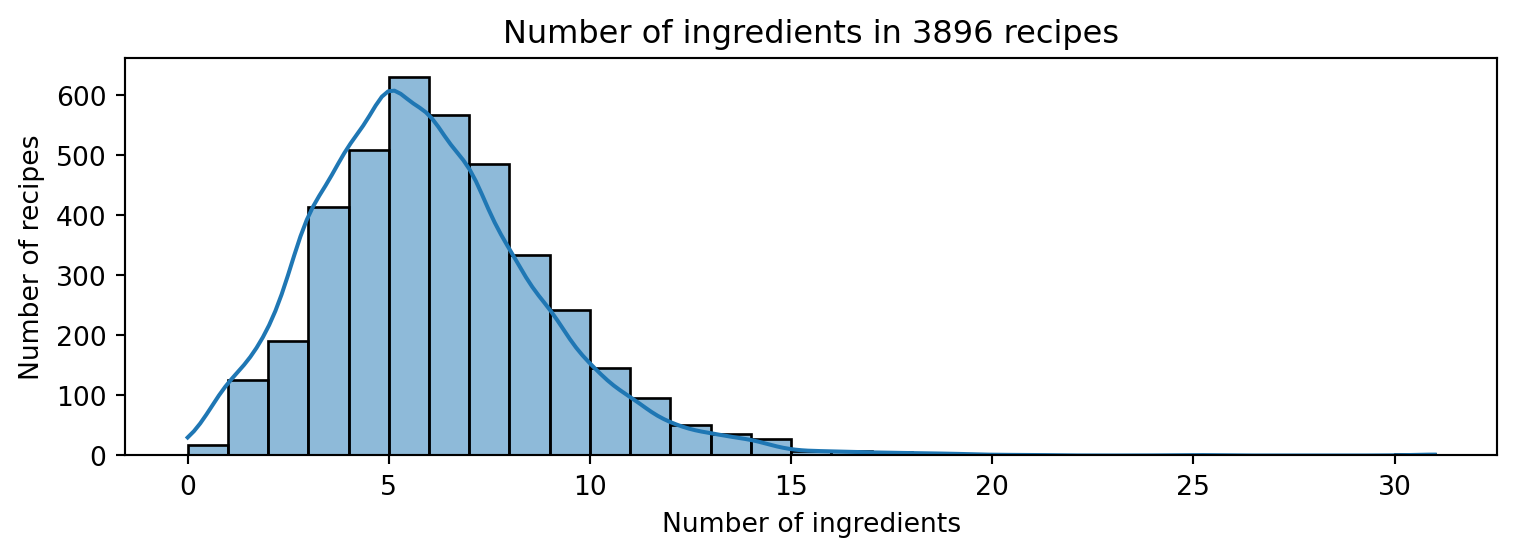

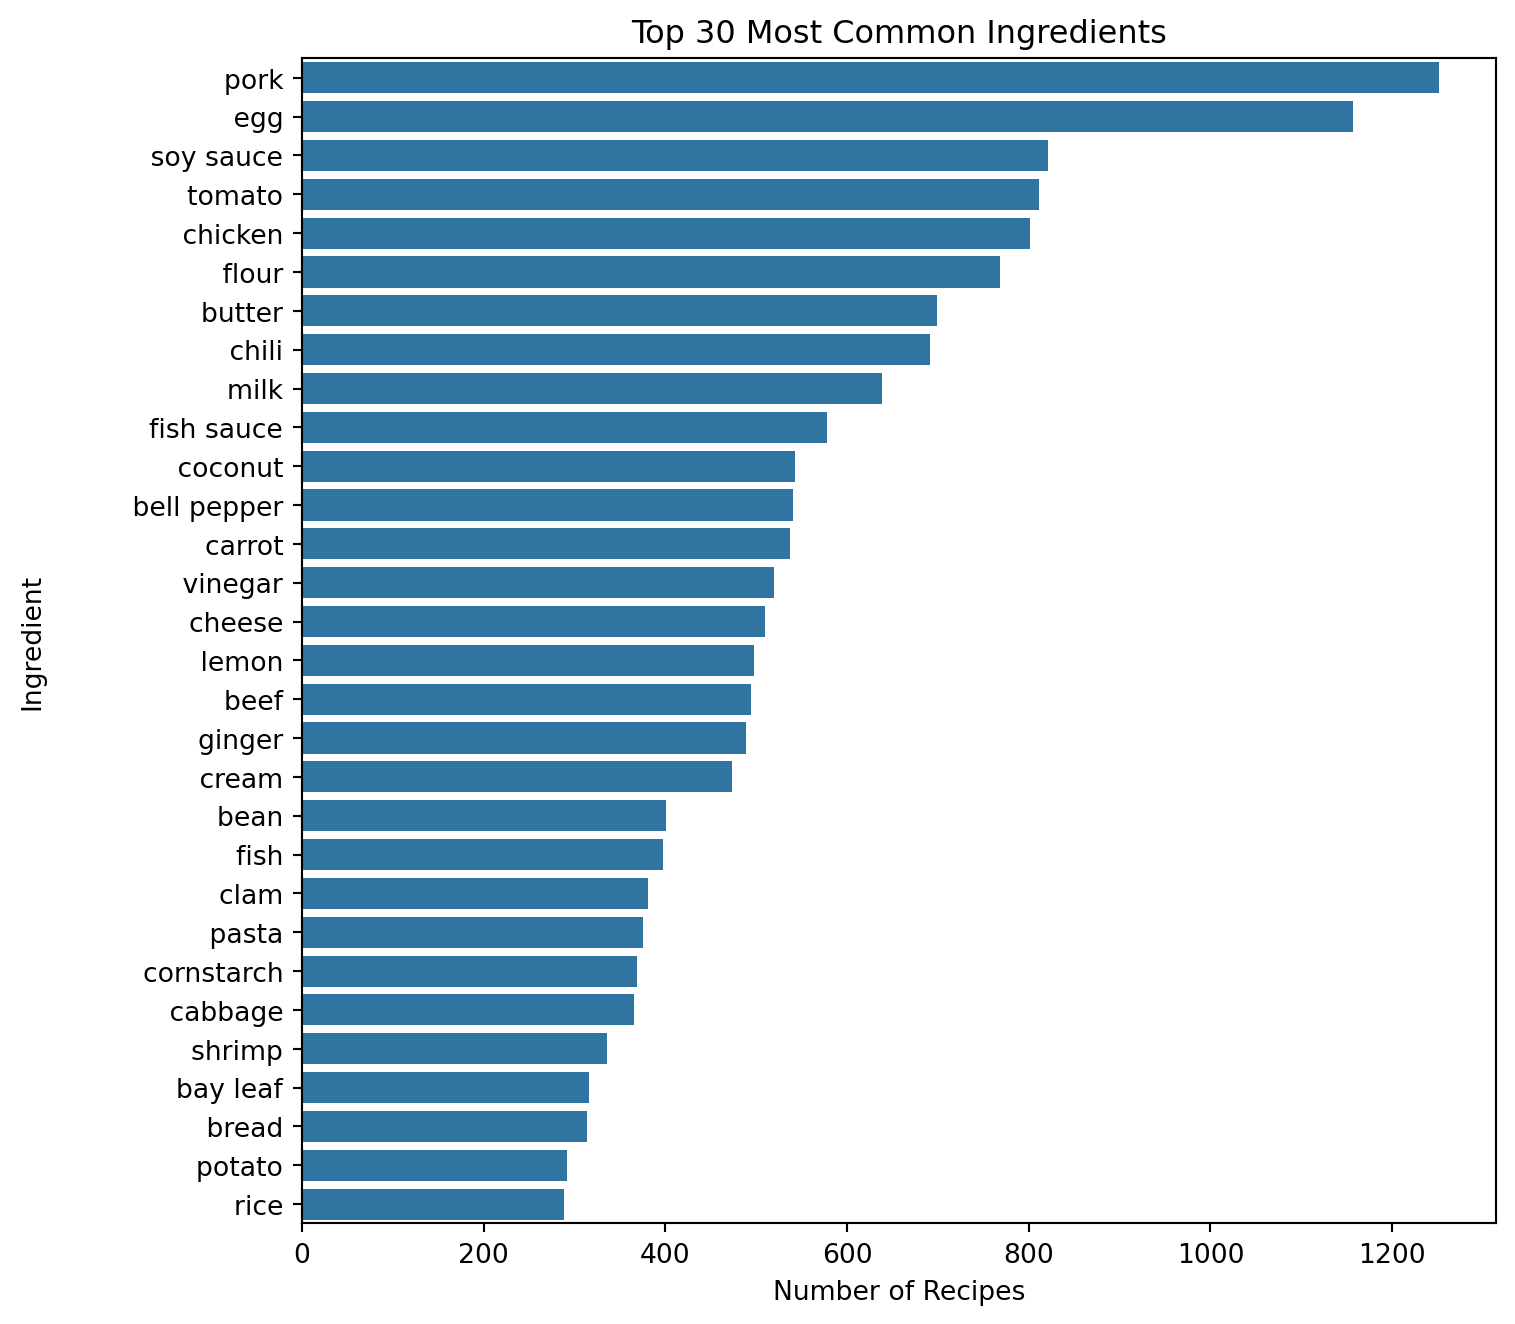

In [26]:
plot_ingredient_count_distribution(recipe_df.filtered_unique)
plot_common_ingredients(recipe_df.filtered_unique)

## Association Analysis

### Convert DataFrame to one-hot encoded format


In [27]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(recipe_df.filtered_unique)
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df = one_hot_df.astype(bool)

one_hot_df.head()

,alcohol,anise,annatto,apple,asparagus,avocado,baking soda,banana,barbecue sauce,basil,...,tofu,tomato,turnip,vanilla,vegetable,vegetable broth,vinegar,wrapper,yam,yeast
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Find frequent itemsets


In [28]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    one_hot_df,
    min_support=0.01, #  Lower this value to get more frequent itemsets
    use_colnames=True,
)

frequent_itemsets.head()

,support,itemsets
0,0.047998,(alcohol)
1,0.013860,(anise)
2,0.021561,(annatto)
3,0.060062,(baking soda)
4,0.044661,(banana)


In [29]:
frequent_itemsets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   support   672 non-null    float64
 1   itemsets  672 non-null    object 
dtypes: float64(1), object(1)
memory usage: 10.6+ KB


### Generate association rules


In [30]:
from mlxtend.frequent_patterns import association_rules

rules_df = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.5,
)

rules_df.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(anise),(soy sauce),0.013860,0.196612,0.010267,0.740741,3.767527,0.007542,3.098783,0.744898
1,(annatto),(fish sauce),0.021561,0.145021,0.011294,0.523810,3.611968,0.008167,1.795457,0.739078
2,(baking soda),(butter),0.060062,0.161961,0.030031,0.500000,3.087163,0.020303,1.676078,0.719279
3,(baking soda),(egg),0.060062,0.268994,0.052875,0.880342,3.272721,0.036719,6.109123,0.738819
4,(baking soda),(flour),0.060062,0.174538,0.051848,0.863248,4.945902,0.041365,6.036191,0.848792


In [31]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543 entries, 0 to 542
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         543 non-null    object 
 1   consequents         543 non-null    object 
 2   antecedent support  543 non-null    float64
 3   consequent support  543 non-null    float64
 4   support             543 non-null    float64
 5   confidence          543 non-null    float64
 6   lift                543 non-null    float64
 7   leverage            543 non-null    float64
 8   conviction          543 non-null    float64
 9   zhangs_metric       543 non-null    float64
dtypes: float64(8), object(2)
memory usage: 42.6+ KB


In [32]:
rules_df["antecedents"] = rules_df["antecedents"].apply(tuple)
rules_df["consequents"] = rules_df["consequents"].apply(tuple)

rules_df.to_csv("data/association_rules.csv", index=False)

## Visualization

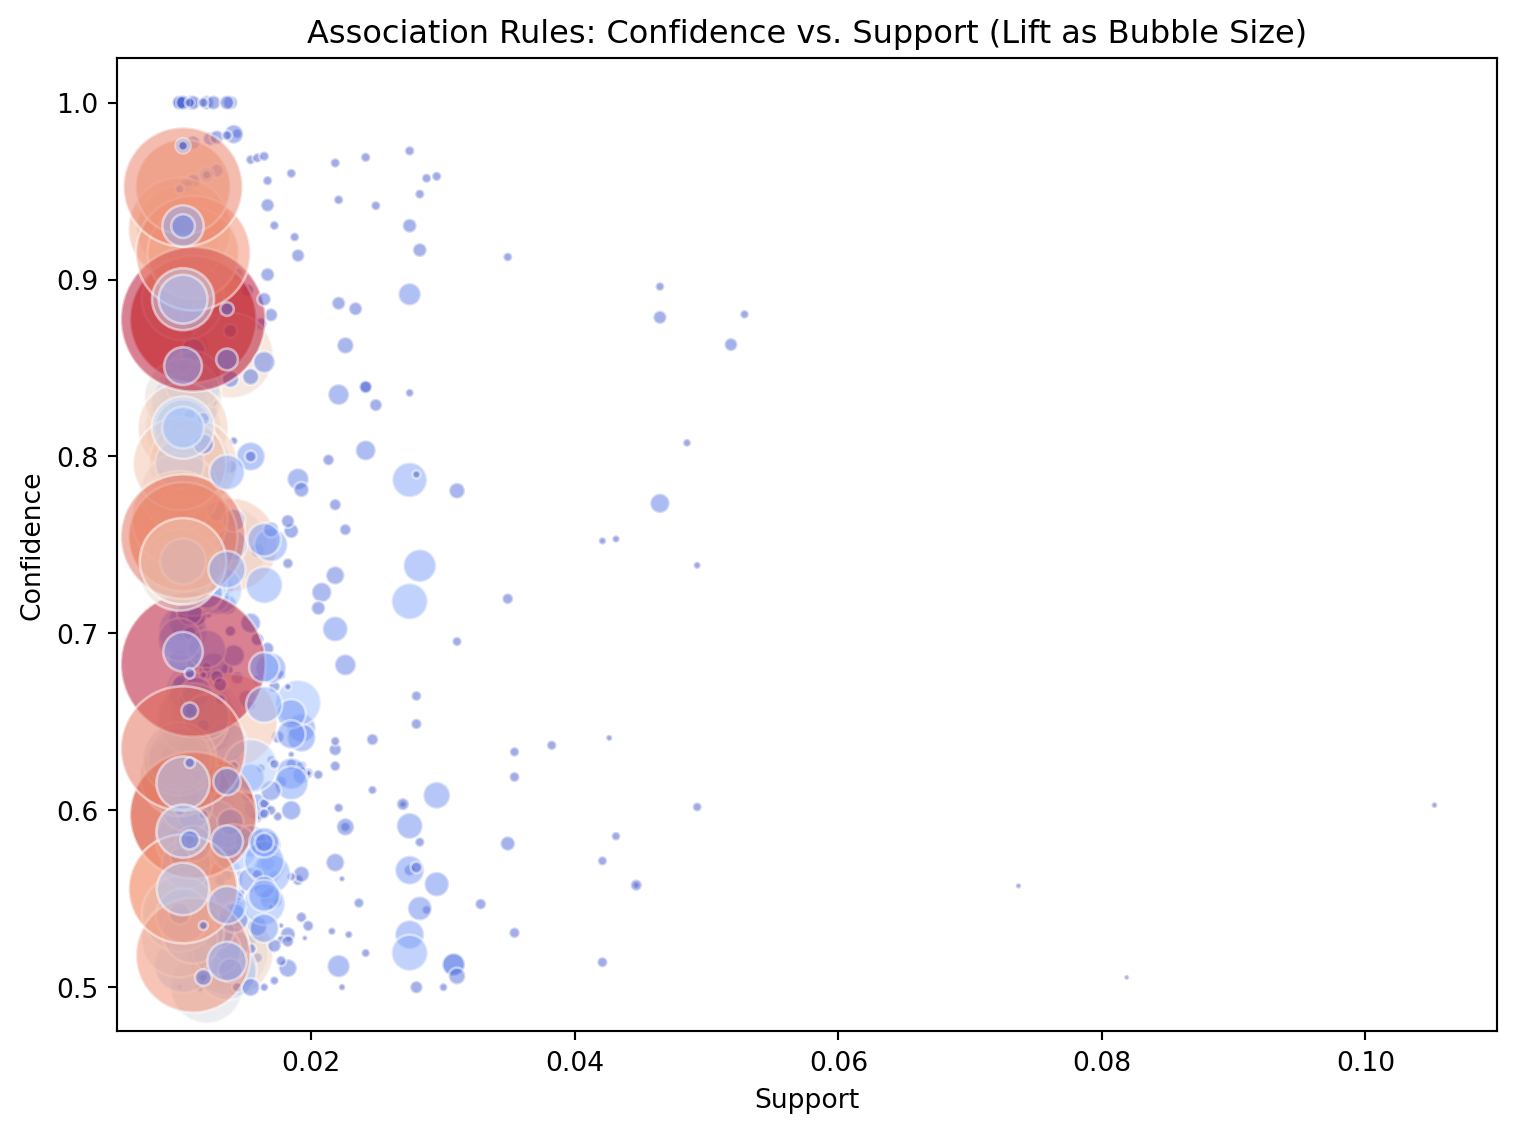

In [33]:
plt.figure(figsize=(8, 6))
plt.scatter(
    rules_df.support,
    rules_df.confidence,
    c=rules_df.lift,
    s=rules_df.lift**2,
    edgecolors="w",
    cmap="coolwarm",
    alpha=0.5,
)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Association Rules: Confidence vs. Support (Lift as Bubble Size)")
plt.tight_layout()
plt.show()

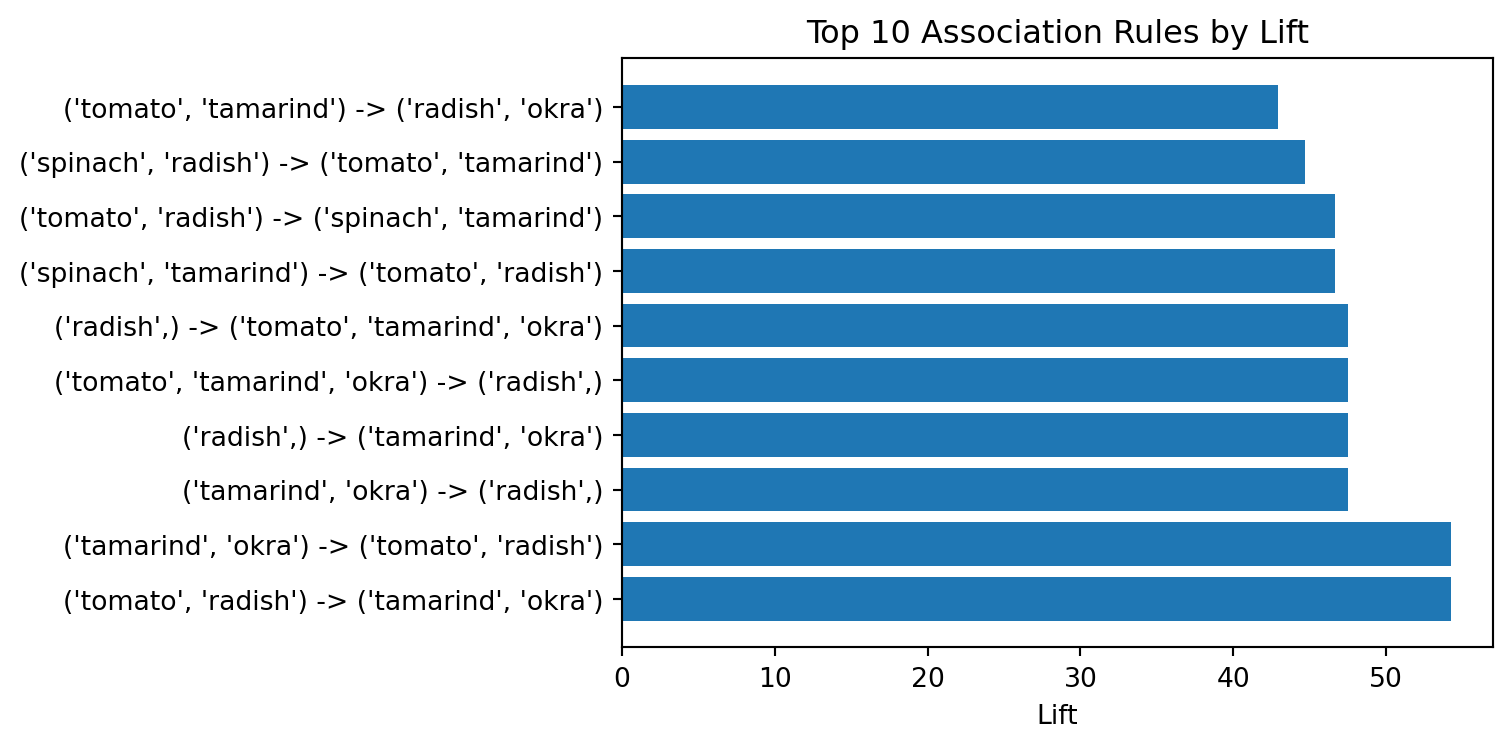

In [34]:
top_n = rules_df.nlargest(10, "lift")
plt.figure(figsize=(8, 4))
bars = plt.barh(
    top_n[["antecedents", "consequents"]].apply(
        lambda x: str(x.iloc[0]) + " -> " + str(x.iloc[1]), axis=1
    ),
    top_n["lift"],
)
plt.xlabel("Lift")
plt.title("Top 10 Association Rules by Lift")
plt.tight_layout()
plt.show()

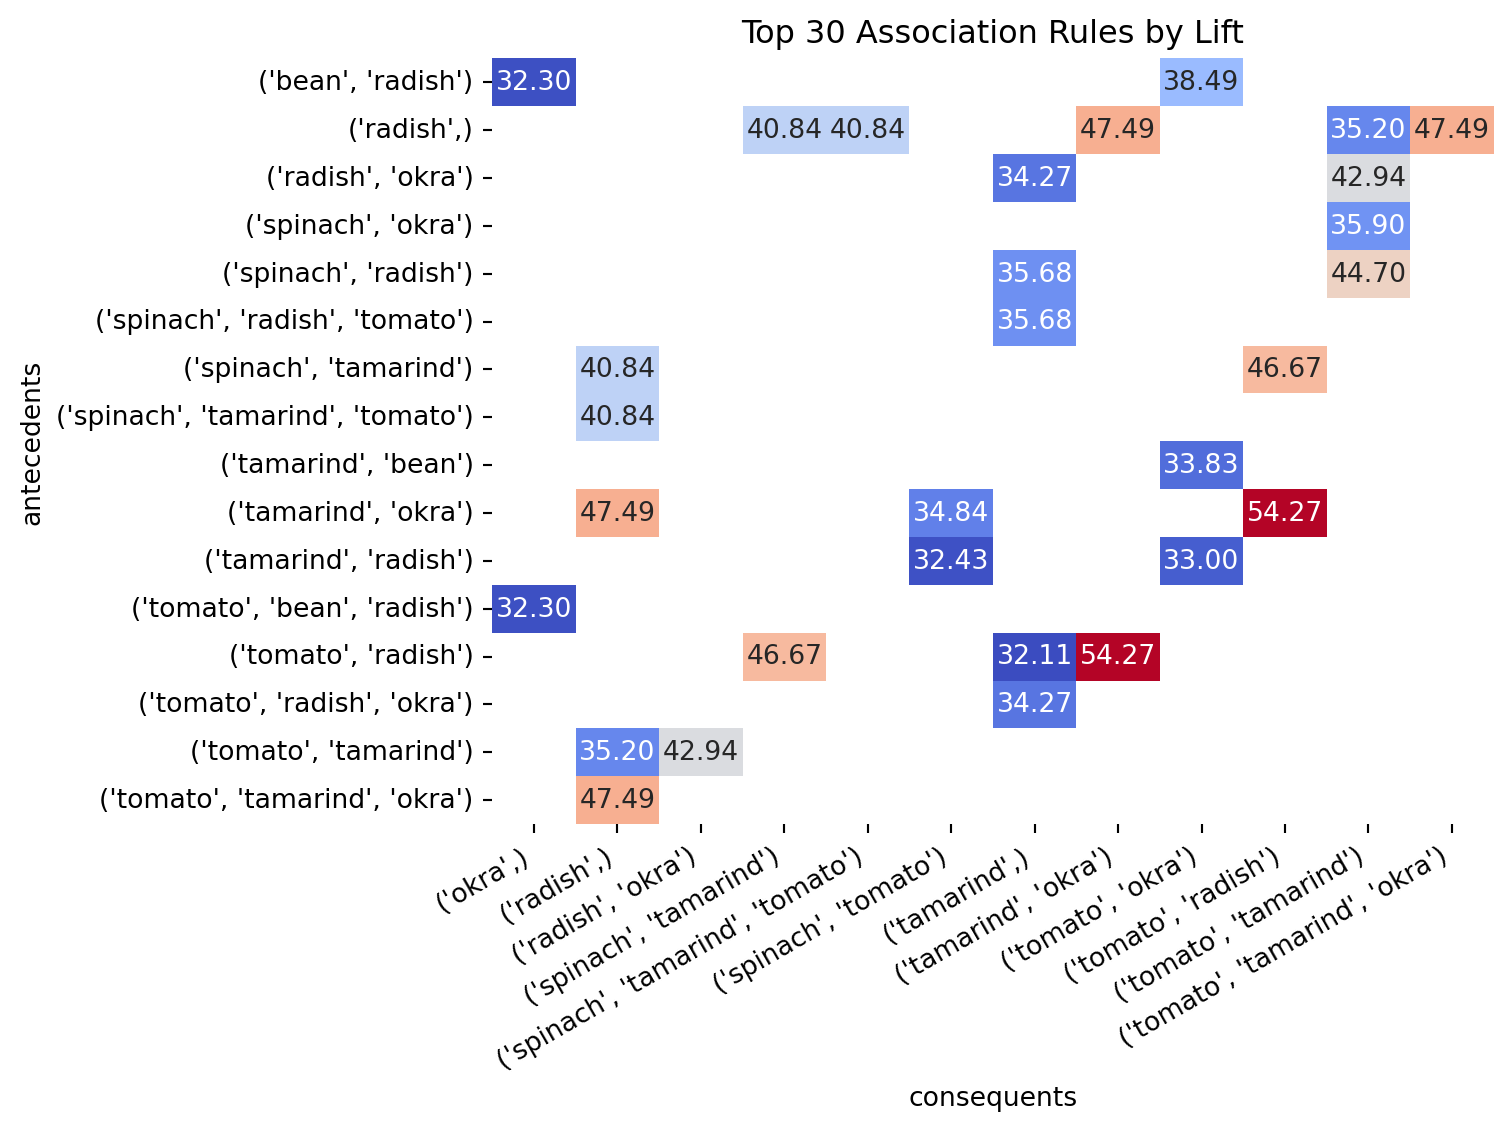

In [35]:
top_rules = rules_df.sort_values("lift", ascending=False).head(30)
pivot = top_rules.pivot(
    index="antecedents",
    columns="consequents",
    values="lift",
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title("Top 30 Association Rules by Lift")
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

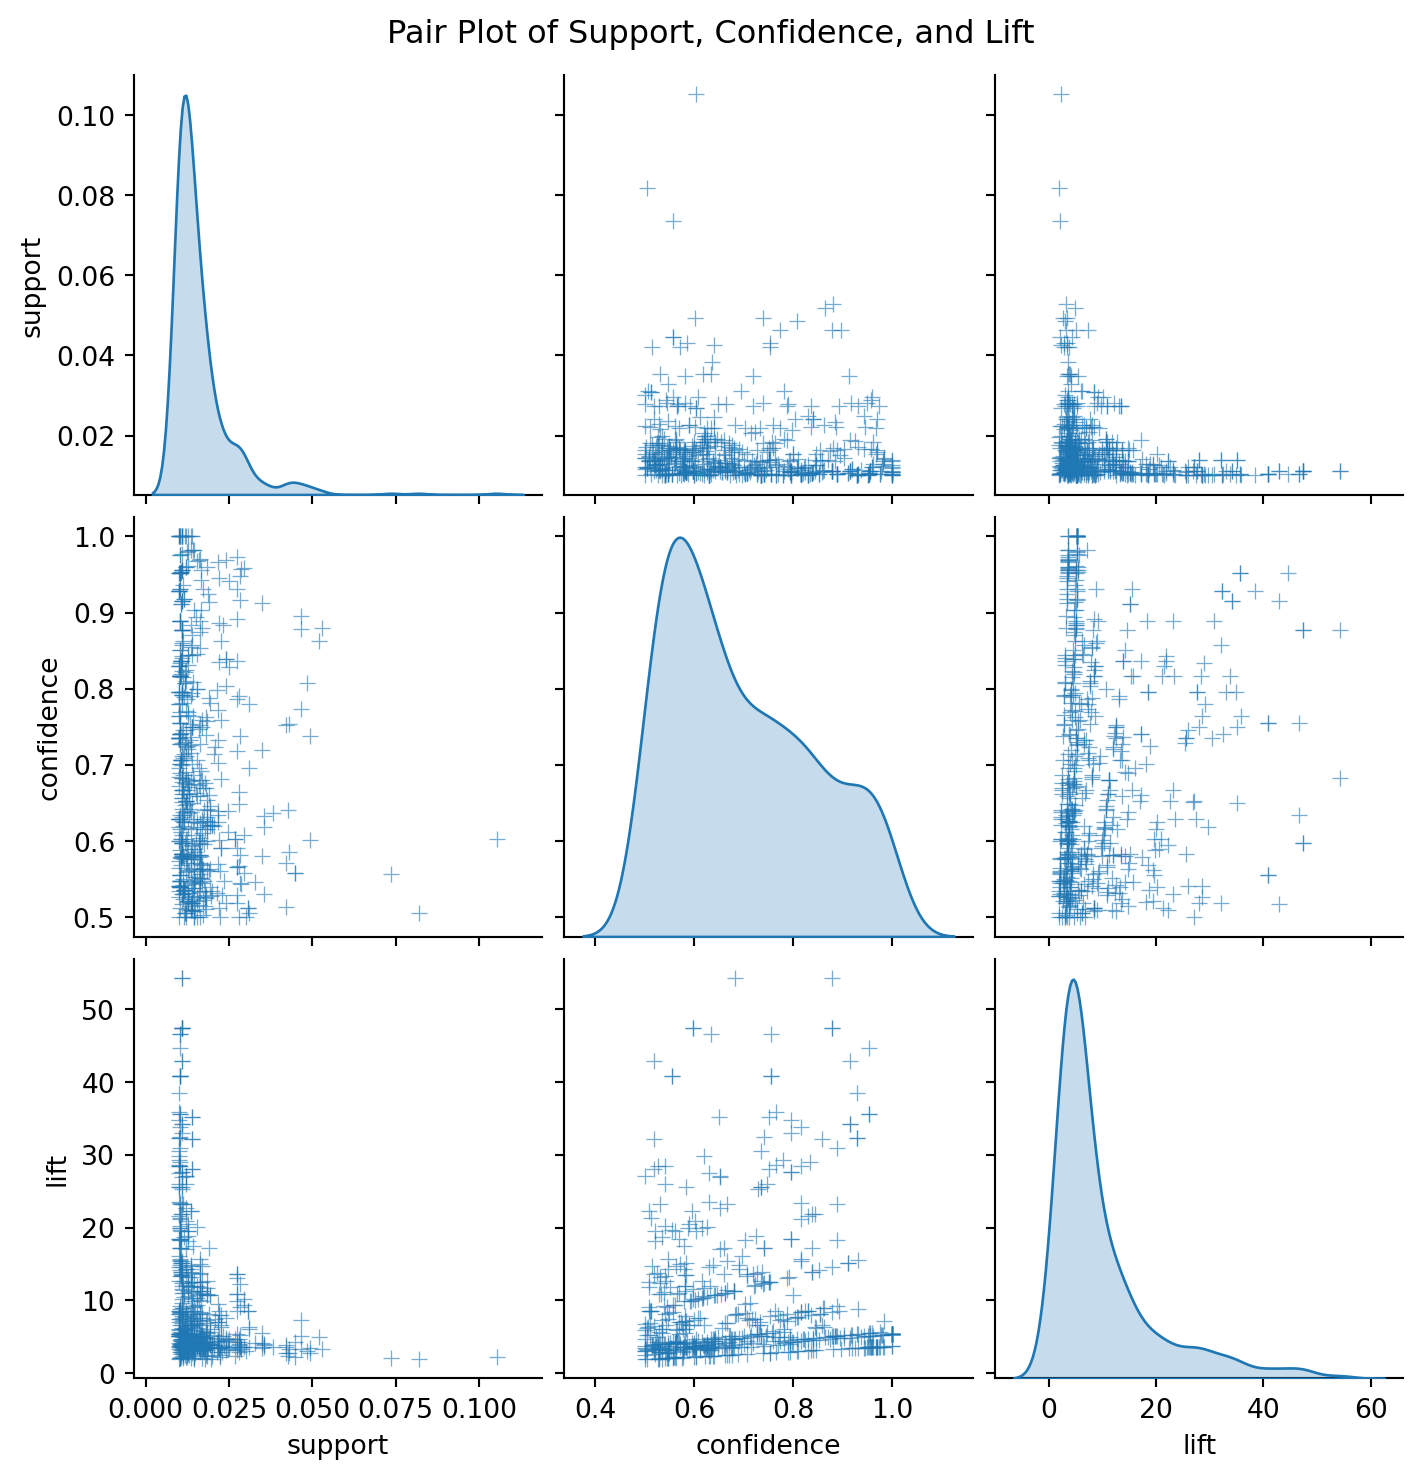

In [36]:
sns.pairplot(
    rules_df[["support", "confidence", "lift"]],
    diag_kind="kde",
    markers="+",
    plot_kws={"alpha": 0.6},
)
plt.suptitle("Pair Plot of Support, Confidence, and Lift", y=1.02)
plt.show()

In [37]:
import plotly.graph_objects as go
import networkx as nx

# Initialize graph and add edges from rules_df
G = nx.Graph()
for _, row in rules_df.iterrows():
    G.add_edge(
        str(row["antecedents"]),
        str(row["consequents"]),
        weight=row["lift"],
    )

# Compute spring layout for node positions
pos = nx.spring_layout(G, k=0.5, iterations=70)

# Prepare edge data for Plotly
edge_x = []
edge_y = []
for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.3, color="#888"),
    hoverinfo="text",
    mode="lines",
)

# Calculate node degrees and prepare node hover text
node_degrees = dict(G.degree())
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]
node_texts = []
node_connections = {
    node: {"outgoing": [], "incoming": []} for node in G.nodes()
}

for edge in G.edges(data=True):
    node_connections[edge[0]]["outgoing"].append(edge[1])
    node_connections[edge[1]]["incoming"].append(edge[0])

for node in G.nodes():
    outgoing = node_connections[node]["outgoing"]
    incoming = node_connections[node]["incoming"]
    hover_text = (
        f"Node: {node}<br><br>"
        f"Consequent of ({len(incoming)}):<br>{'<br>'.join(incoming[:10])}<br><br>"
        f"Antecedent of ({len(outgoing)}):<br>{'<br>'.join(outgoing[:10])}"
    )
    node_texts.append(hover_text)
node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode="markers",
    text=node_texts,
    hoverinfo="text",
    marker=dict(size=10, line=dict(width=1, color="#222")),
)

# Create and display figure
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title="Association Rule Network Graph",
        titlefont_size=16,
        showlegend=False,
        hovermode="closest",
        margin=dict(b=20, l=20, r=20, t=40),
        annotations=[
            dict(text="", showarrow=False, xref="paper", yref="paper")
        ],
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    ),
)
fig.show()